# Application of the Dynamic Ising Model to Chemotactic Receptors 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
import animatplot as amp

## Introduction

Following the previous notebooks, we now aim to use the Ising model to capture the activity of chemotactic receptor arrays. While we knew what to expect and look for in the Ising model, this part becomes more exploratory, so we shall try different approaches and see what works best for our purposes. Ultimately, we want that our model captures at least two things:

- dynamic range in response to ambient ligand concentration;
- adaptation after a step change in concentration.

For this purpose, we realise that our model should incorporate ligand binding (in order to respond to a changing concentration) and methylation (as a feedback mechanism necessary for adaptation). Naively, we may resort to the idea behind the kinetic MWC model we wrote, where each receptor has a three-component state vector specifying the ligand binding, methylation and activity. In principle, we could think of doing something similar for the Ising model, but this would give a computationally and conceptually complex model. While keeping this option in the back of our mind, we first explore whether there may be a more straightforward approach to incorporate ligand binding and methylation into our model.

## Concentration-dependent External Field

We shall first focus on incorporating ligand concentration into the Ising model. For now, we assume that ligand binding and unbinding are very fast processes, such that the explicit dynamics can be integrated out. This means that only the ambient ligand concentration $c$ matters for the dynamics of our system at the time scale of interest. 

Following Skoge et al. (2011), we incorporate these considerations into the Ising model by letting the external field $H$ depend on the ligand concentration, while we take a slightly different approach than Skoge et al. Concretely, inspired by the MWC model, the free-energy difference $f$ between the active and inactive confirmation per receptor is

$$ f = \epsilon_0 + \log \frac{1 + c/K_D^I}{1 + c/K_D^A}, $$

where $\epsilon_0$ is the energy difference between the active and inactive state in the absence of ligand, and $K_D^{I}$ and $K_D^{A}$ are the dissociation constants for the inactive and active confirmation, respectively. Note that throughout this work, we use units where $k_\text{B} T = 1$ and that this energy does not depend on the activity of a receptor. The total energetic cost from receptors that are in the active rather than inactive state is then

$$ F = f\sum_{i=}^N a_i, $$

where $a_i = 0,1$ denotes the activity variable of receptor $i$. We would like to formulate the Ising model in terms of spin variables, so we rewrite the above as

$$F = f\sum_{i=1}^N\left(\frac{1}{2} + \frac{1}{2}s_i \right) = \frac{1}{2}N f + \frac{1}{2} f \sum_{i=1}^N s_i.$$

We incorporate this into the Ising model through as an external field $-F$, because by our convention, a higher free energy should corresponds to a higher probability of being inactive, which is enforced through this minus sign. The expression for the hamiltonian is then 

$$ \mathcal{H}(\mathbf{s}) = -J\sum_{(i,j)} s_i s_j + \frac{1}{2}N f + \frac{1}{2} f \sum_{i=1}^N s_i. $$

The corresponding flipping rates are

$$ \omega_i = \omega_0 \exp\left\{-J s_i \sum_{(i,j)}s_j + \frac{1}{2} f s_i \right\}. $$

This approach lends itself for a useful interpretation. Concretely, we can view the term in $\epsilon_0$ as a 'bias' for the receptors to be in either an active or inactive confirmation. In fact, at equilibrium, receptors tend to favour the inactive confirmation and $\epsilon_0$ is a parameter that allows us to capture this. Notice that the constant offset in $Nf$ should not affect the dynamics, as these only depend on energy differences between the active and inactive state. Furthermore, based on the above expression, we expect that the system will have a wide dynamic range, as it responds to changes in $\log c$ rather than $c$ itself. As such, this seems like a promising first step in applying the Ising model to bacterial chemotaxis.


In [2]:
@numba.jit(nopython=True)

# this function determines the coupling energy based on the location of the spin
def rates_2d_numba(J,H,state,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field))

In [3]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ising_2d_lig(n_sims,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):
    # initialise
    state = np.random.choice(np.array([-1.,1.]),size=(L,L))

    # array to store all results
    all_states = np.zeros((n_sims,L,L))
    all_states[0,:,:] = state

    # store all waiting times
    waiting_times = np.zeros(n_sims)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    # perform Gillespie's algorithm
    for k in range(1,n_sims):
        # change concentration after some steps
        if k >= step_change:
            c = cnew
        else:
            c = cbase
        
        # define the external field 
        H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
        
        # obtain rates of flipping
        rates = rates_2d_numba(J,H,state)
        Omega = np.sum(rates)

        # sample time until next event
        u1 = np.random.uniform(0,1)
        dt = -np.log(u1)/Omega
        waiting_times[k] = dt
        
        # select which spin i is flipped
        p = np.random.uniform(0,1)*Omega
        mask = p < np.cumsum(rates)
        i = np.where(mask == True)[0][0]
        
        # convert to coordinates in the lattice
        m,l = np.divmod(i,L)

        # flip the selected spin and save it
        state[m,l] *= -1
        all_states[k,:,:] = state
        
    return all_states, waiting_times

### Basic verification

We would like to verify that our current model maps well to the original Ising model, from which we know that at equilibrium and without coupling, the average spin satisfies

$$ m = \tanh(H). $$

We translate this to the average activity and with the current expression for the external field as

$$ a = \frac{1}{2} + \frac{1}{2}\tanh\left[-\frac{1}{2}\left(\epsilon_0 + \log \frac{1+c/K_i}{1+c/K_a} \right) \right], $$

so we check whether our simulation and theory agree on this. Furthermore, we have chosen $\epsilon_0$ such that without coupling, the equilibrium activity is 0.5 for a baseline concentration of 100 $
mu$M. The reason is that this makes interpreting the dose-response curves later on a bit more straightforward. We can set $a=1/2$ in the above expression to get

$$ \epsilon_0 = -\log \frac{1+c/K_i}{1+c/K_a}, $$

which we use to determine $\epsilon_0$ at $c=100$ $\mu$M.

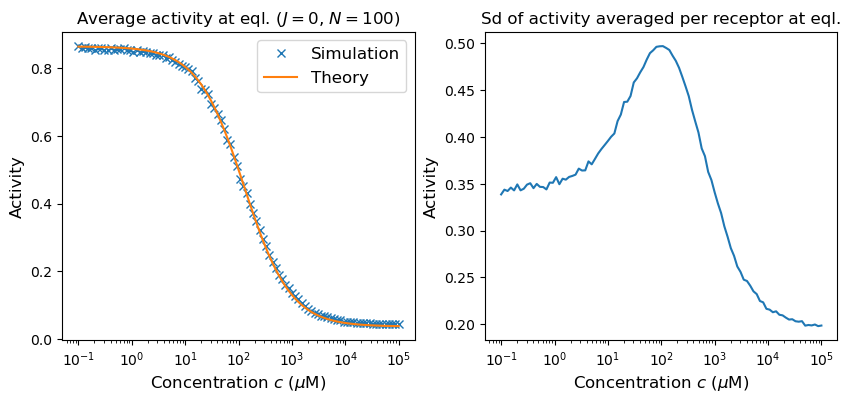

In [4]:
# check how this goes
n_sims = 10**4
L = 10
J = 0

c_arr = np.logspace(-1,5,10**2)
all_avg_spin = np.empty(c_arr.size)
all_std_spin = np.empty(c_arr.size)

# loop through various concentrations
for i,c in enumerate(c_arr):    
    # obtain average magnetisation at equilibrium
    spins, waiting_times = ising_2d_lig(n_sims,L,J,cbase=c)
    std_spin = np.std(spins,axis=(1,2))
    avg_spin = np.mean(spins,axis=(1,2))
    
    # truncate and take mean
    all_avg_spin[i] = np.mean(avg_spin[n_sims//3:])
    all_std_spin[i] = np.mean(std_spin[n_sims//3:])
    
# convert to activity
all_avg_act = 0.5 + 0.5*all_avg_spin
all_std_act = 0.5*all_std_spin

# check theoretical result
def theoretical_a(c,L,Ki=18,Ka=2900):
    epsilon = -np.log((1+100/Ki)/(1+100/Ka))
    return 0.5 + 0.5*np.tanh(-0.5*(epsilon + np.log((1+c/Ki)/(1+c/Ka))))

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.semilogx(c_arr,all_avg_act,'x',label='Simulation')
ax1.semilogx(c_arr,theoretical_a(c_arr,L),label='Theory')
#ax1.axvline(x=c_crit,ymin=0.05,ymax=0.95,color='r',linestyle=':')
ax1.set_xlabel(r'Concentration $c$ ($\mu$M)',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.legend(fontsize=12)
ax1.set_title(f'Average activity at eql. ($J = {J}$, $N={L**2}$)')

ax2.semilogx(c_arr,all_std_act,label='Average std at eql.')
ax2.set_xlabel(r'Concentration $c$ ($\mu$M)',size=12)
ax2.set_ylabel('Activity',size=12)
ax2.set_title('Sd of activity averaged per receptor at eql.')

plt.show()

## Phase transition

The above results that even if we only take one measurement per value of $c$, we find excellent agreement between theory and simulation! Do note that for low $c$, the average activity per receptor fluctuates substantially in time. Still, we expect that that the mean has a narrow distribution. Verifying this would require multiple simulations per $c$ to get a sampling distribution. For now, we are happy with our result and move onto to verifying whether the simulation displays a continuous phase transition in $J$. 

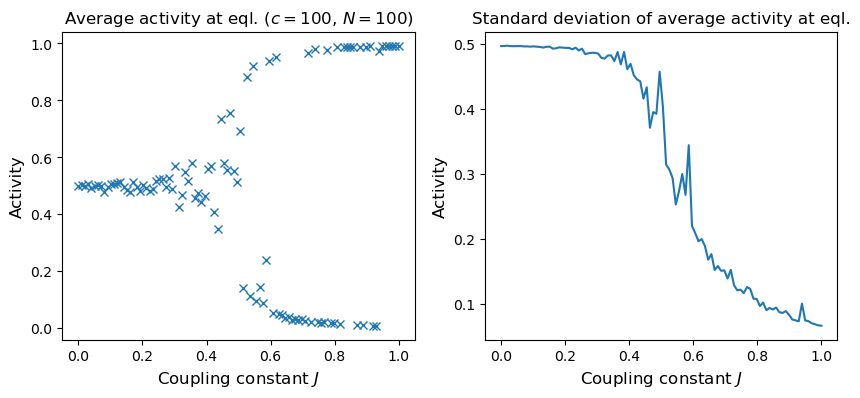

In [5]:
# obtain activity as function of J without external field
n_sims = 10**4
L = 10
c = 100

J_arr = np.linspace(0,1,10**2)
all_avg_spin = np.empty(J_arr.size)
all_std_spin = np.empty(J_arr.size)

# loop through various concentrations
for i,J in enumerate(J_arr):
    # obtain average magnetisation at equilibrium
    spins, waiting_times = ising_2d_lig(n_sims,L,J,cbase=c)
    std_spin = np.std(spins,axis=(1,2))
    avg_spin = np.mean(spins,axis=(1,2))
    
    # truncate and take mean
    all_avg_spin[i] = np.mean(avg_spin[n_sims//3:])
    all_std_spin[i] = np.mean(std_spin[n_sims//3:])
    
# convert to activity
all_avg_act = 0.5 + 0.5*all_avg_spin
all_std_act = 0.5*all_std_spin

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.plot(J_arr,all_avg_act,'x',label='Simulation')
ax1.set_xlabel(r'Coupling constant $J$',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.set_title(f'Average activity at eql. ($c = {c}$, $N={L**2}$)')

ax2.plot(J_arr,all_std_act,label='Average std at eql.')
ax2.set_xlabel(r'Coupling constant $J$',size=12)
ax2.set_ylabel('Activity',size=12)
ax2.set_title('Standard deviation of average activity at eql.')

plt.show()

<IPython.core.display.Javascript object>


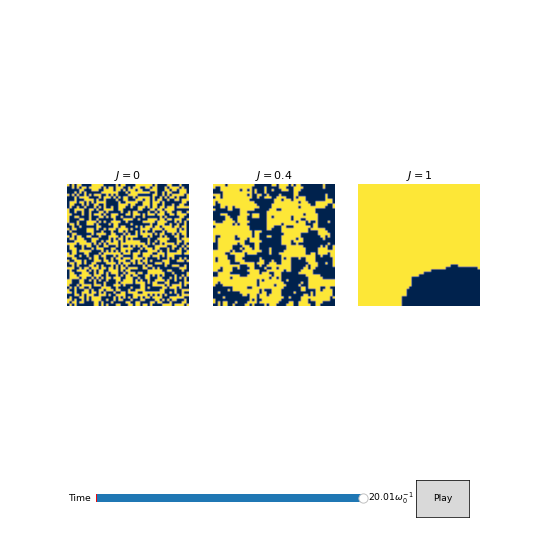

In [7]:
# interactive plot
%matplotlib notebook

n_sims = 5*10**4
L = 50
c = 100

# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

spin_low_J, waiting_times = ising_2d_lig(n_sims,L,0.,cbase=c)

spin_medium_J, _ = ising_2d_lig(n_sims,L,0.4,cbase=c)

spin_high_J, _ = ising_2d_lig(n_sims,L,1.,cbase=c)

# show the receptor cluster dynamically
fig = plt.figure(figsize=(8,8))

# Create 1x3 sub plots
gs = gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

# formatting
ax1.set_axis_off()
ax1.set_title(f'$J=0$')

ax2.set_axis_off()
ax2.set_title(f'$J=0.4$')

ax3.set_axis_off()
ax3.set_title(f'$J=1$')

# extract image objects for colorbars
im1 = ax1.imshow(spin_low_J[0,:,:], cmap=plt.cm.gray)

# create a timeline for the animation
timeline = amp.Timeline(np.cumsum(waiting_times), units=r'$\omega_0^{-1}$', fps=500)

# create animation blocks for the lattices
block1 = amp.blocks.Imshow(0.5*spin_low_J + 0.5, ax=ax1, cmap=plt.cm.cividis)
block2 = amp.blocks.Imshow(0.5*spin_medium_J + 0.5, ax=ax2, cmap=plt.cm.cividis)
block3 = amp.blocks.Imshow(0.5*spin_high_J + 0.5, ax=ax3, cmap=plt.cm.cividis)


# create the animation and add a time bar
anim = amp.Animation([block1, block2, block3], timeline)
anim.controls()

plt.show()

In [8]:
del(ax1, ax2, ax3)
%matplotlib inline

## Ensemble averaging

Our previous results indicate that the basic structure of our model is sensible. For future implementations, it is beneficial to look at ensemble-averaged results. Naively, we would simulate several trajectories and average those. The problem is that the time steps differ per realisation, as these are random variables. Consequently, we need another approach to take an ensemble average. 

Our idea is to have a regularly space grid of time points. Between any two of those time points, we let the simulation run and keep a record of the cumulative waiting times. Once the sum of waiting times crosses the later of the two regular time points, we save the state of the system just before it crossed this time point. In this way, we have regularly spaced times as well as regularly spaced samples of the system's state at each of those times. We can then obtain several realisations in this way and take an ensemble average. 

In [4]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):

    # array to store all results
    all_states = np.zeros((n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over n_samples realisations of the algorithm
    for sample in range(n_samples):
        # initialise each realisation
        dt = 0
        time = 0
        
        # initialise
        state = np.random.choice(np.array([-1.,1.]),size=(L,L))
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # flip the spin
                state[m,l] *= -1
                
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
            # save the last state before passing the boundary
            all_states[sample,step,:,:] = state
            
    #################
    ### Averaging ###
    #################
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                ensemble_av[step,spin1,spin2] = np.mean(all_states[:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

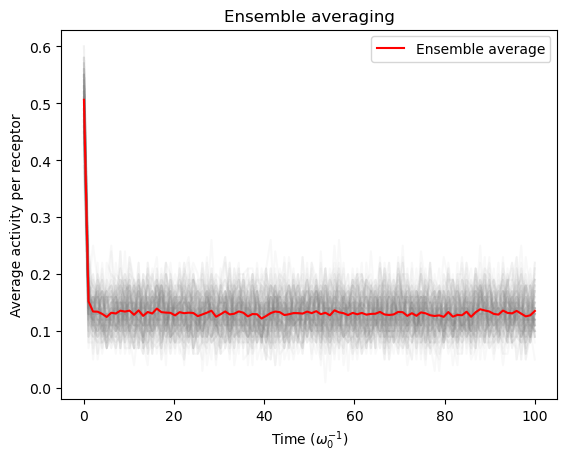

In [11]:
# check whether this works
n_samples = 10**2
n_steps = 10**2
tf = 100
L = 10
J = 0

# obtain results
all_states, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,cbase=10**3)

# convert to activity 
ensemble_av_act = 0.5*(ensemble_av + 1)

# look at ensemble-averaged activity averaged over all spins for one realisation
for ff in range(n_samples):
    plt.plot(t_grid,0.5+0.5*np.mean(all_states[ff,:,:,:],axis=(1,2)),color='grey',alpha=0.05)
    
plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),color='red',label='Ensemble average')
plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Average activity per receptor')
plt.title('Ensemble averaging')
plt.legend()
plt.show()

## Dose-response curve

A defining feature of cooperative receptors is that they display an S-shaped dose-response curve. We would like to see whether our model captures this behaviour. Intuitively, cooperativity depends strongly on the coupling constant $J$, so we produce a dose-response curve for various values of $J$. This should already reveal what a reasonable value for $J$ is, since we insist that our model can capture cooperative binding. 

We extract the response as follows. The system is simulated from a random initial state with a baseline concentration of 100 $\mu$M. At some timestep (chosen late enough such that the system can equilibrate), we change the concentration for the rest of the simulation. We simulate several trajectories in this way, take an ensemble average over them, and then define the response as the difference between the mean activity before and after the concentration change (where we ignore the transient briefly after the stimulus is presented). 

In [5]:
@numba.jit(nopython=True)
def dose_response_curve(n_samples,n_steps,tf,L,J_arr,cnew_arr):
    # set when the concentration is changed
    step_change = int(np.floor(0.4*n_steps))

    # store results
    all_responses = np.zeros((J_arr.size,cnew_arr.size))

    # perform simulation for various J and cnew
    for i,J in enumerate(J_arr):
        # loop for various new concentrations
        for j, c_new in enumerate(cnew_arr):
            # obtain results
            _, ensemble_av, _ = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                                                                      step_change=step_change,cnew=c_new)
                        
            # extract activity, weird numba way
            av_spin = np.sum(np.sum(ensemble_av,axis=-1),axis=-1)/L**2
            activity = 0.5*(av_spin + 1)

            # set baseline and extract new equilibrium
            baseline = np.mean(activity[1000:step_change-1]) # remove transient
            new_act = np.mean(activity[-1000:])

            # save response
            all_responses[i,j] = new_act - baseline
            
    return all_responses

### Hill coefficient

In addition to plotting the dose-response curve, we would like to quantify the sensitivity of the receptor cluster in a single number. A reasonable choice for this is the Hill coefficient $n_H$. That is, we expect that the dose-response curve for a given value $J$ can be approximated by

$$ \Delta a(c) = \frac{c^{n_H}}{K + c^{n_H}} - \frac{1}{2}  $$

for some apparent dissociation constant $K$. Note that $c$ denotes the final concentration in our procedure for obtaining the response. The Hill coefficient is a measure for the steepness of the dose-response curve. This means that a larger absolute value of $n_H$ indicates a more sensitive receptor cluster. We suspect that this sensitivity depends on how cooperative the receptors are, such that we expect $|n_H|$ to increase with $J$. After all, receptors that act in unison are more likely to pick up on even small environmental changes than a cluster of receptors that react independently to stimuli. 

We added the term $1/2$ by hand. A Hill function has values between 0 and 1, whereas we compute $\Delta a$ with respect to a baseline activity of $1/2$. As such, up to some noise around the baseline level, $\Delta a$ ranges between $1/2$ and $-1/2$, so we shift the Hill function down to accommodate this.

Actually, we can relate $K$ to the baseline concentration $c_0$ we chose. After all, by definition, if the final concentration $c$ equals the initial concentration $c_0$, the response must be zero. Hence, solving the equation $\Delta a(c_0) = 0$ for $K$, we find

$$ K = c_0^{n_H}. $$

Since we fix $c_0 = 100 \, \mu$M, the Hill coefficient remains the only unknown in the expression for $\Delta a$. Still, it is good to verify this theory. Our approach for extracting the Hill coefficients and $K$ is through fitting. That is, once we have obtained the dose-response curve for a given $J$, we fit a Hill function with fitting parameters $n_H$ and $K$ to our simulated data. Repeating this for various $J$ then reveals how $n_H$ (and $K$) depend on $J$. We then plot $K$ versus $n_H$ and compare this with our prediction that $K = 100^{n_H}$. 

In this part, we only show the dose-response curves for a relatively small lattice. We explore size effects using the computer cluster, so please see the other notebook for this.

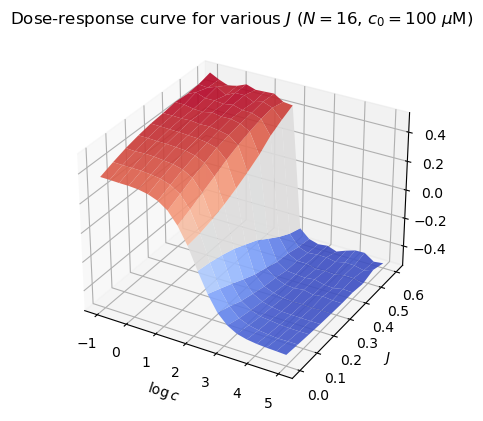

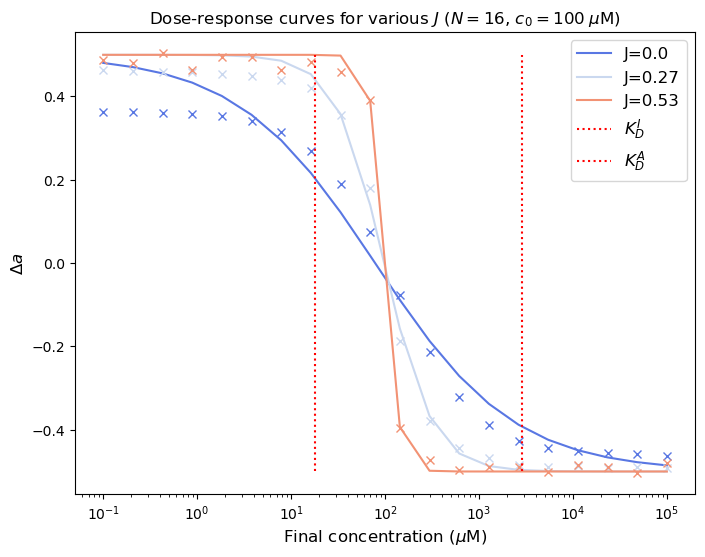

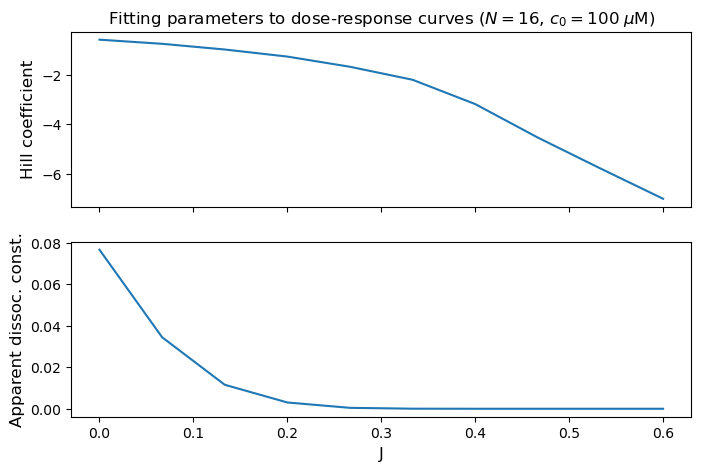

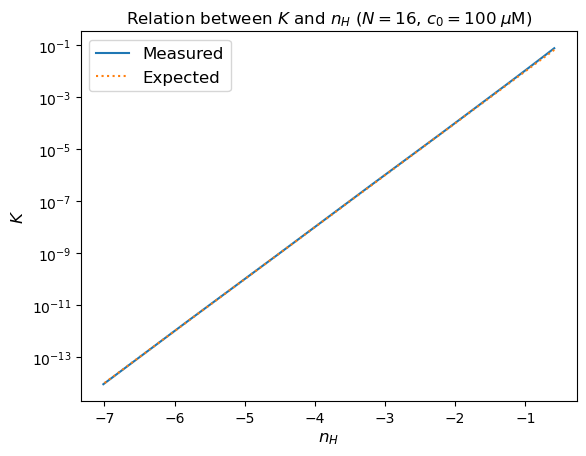

In [13]:
# define Hill function
def hill_func(conc,nH,K):
    return conc**nH/(K + conc**nH) - 0.5

# make a meshgrid for plotting
J_arr = np.linspace(0,0.6,10)
cnew_arr = np.logspace(-1,5,20)
J_plot, c_plot = np.meshgrid(J_arr,cnew_arr)

# parameters
n_samples = 10**2
n_steps = 5000
tf = 10**3
L = 4

##################
## 3D DRC plane ##
##################

# extract dose-response curves
all_responses = dose_response_curve(n_samples,n_steps,tf,L,J_arr,cnew_arr)

# show results
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(np.log10(c_plot).T, J_plot.T, all_responses,cmap=plt.cm.coolwarm,alpha=0.9,label='Simulation')
ax.set_xlabel(r'$\log c$')
ax.set_ylabel('$J$')
ax.set_title(f'Dose-response curve for various $J$ ($N={L**2}, \, N_s={n_samples}$, $c_0=100 \; \mu$M)')
plt.show()

#############
## Fitting ##
#############

# prepare figure
fig, ax = plt.subplots(1,1, figsize=(8,6))

# arrays to save results
parm_arr = np.zeros((2,J_arr.size))
var_arr = np.zeros_like(parm_arr)

# obtain the fitting parameters for each J
for j in range(J_arr.size):
    popt, pcov = curve_fit(hill_func,cnew_arr,all_responses[j,:],maxfev=5000)
    parm_arr[:,j] = popt
    var_arr[:,j] = [pcov[k,k] for k in range(2)]

    # visual inspection for some results
    if j % 4 == 0:
        ax.semilogx(cnew_arr,all_responses[j,:],'x')
        ax.semilogx(cnew_arr,hill_func(cnew_arr,*popt),label=f'J={np.round(J_arr[j],2)}')

#############
## Results ##
#############

# get a nice color map
colormap = matplotlib.colormaps.get_cmap('coolwarm')

# count the number of plots
ax = plt.gca()
lines = ax.lines
n_plots = len(lines)

# apply the same color to each pair of plots
for plot in range(0, n_plots, 2):
    # choose a colour
    random_color = colormap(plot/n_plots + 0.1)
    
    # colour the plots
    lines[plot].set_color(random_color)
    lines[plot+1].set_color(random_color)

# figure formatting
ax.axvline(x=18,ymin=0.05,ymax=0.95,label=r'$K_D^I$',linestyle=':',color='r')
ax.axvline(x=2900,ymin=0.05,ymax=0.95,label=r'$K_D^A$',linestyle=':',color='r')
ax.set_xlabel(r'Final concentration ($\mu$M)',size=12)
ax.set_ylabel(r'$\Delta a$',size=12)
ax.legend(fontsize=12)
ax.set_title(f'Dose-response curves for various $J$ ($N=${L**2}, $c_0=100 \; \mu$M)')
plt.show()

# show fitting parameters as functions of J
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,5),sharex=True)

ax1.plot(J_arr,parm_arr[0,:],'o')
ax1.set_ylabel('Hill coefficient',size=12)
ax1.set_title(f'Fitting parameters to dose-response curves ($N=${L**2}, $c_0=100 \; \mu$M)')

ax2.plot(J_arr,parm_arr[1,:],'o')
ax2.set_ylabel('Apparent dissoc. const.',size=12)
ax2.set_xlabel('J',size=12)

plt.show()

# show the expected relation between the Hill coefficient and K
plt.semilogy(parm_arr[0,:],parm_arr[1,:],'o',label='Measured')
plt.semilogy(parm_arr[0,:],10**(2*parm_arr[0,:]),':',label='Expected')
plt.ylabel(r'$K$',size=12)
plt.xlabel(r'$n_H$',size=12)
plt.legend(fontsize=12)
plt.title(f'Relation between $K$ and $n_H$ ($N=${L**2}, $c_0=100 \; \mu$M)')
plt.show()

#### Interpretation

Even though we only obtained coarse results for a small cluster, these results are informative. Firstly, the dose-response curves are clearly S-shaped. This means that using a Hill function for fitting is reasonable. Perhaps counterintuitively, the dose-response curve is also S-shaped for $J=0$, meaning that the receptors are cooperative even in the absence of coupling. At first glance, this is a contradiction. However, recall that for ligand binding, we use an MWC-based free-energy difference between the active and inactive state. Cooperativity is assumed in the MWC model, so the receptors are indeed binding ligand cooperatively, even if our coupling constant $J$ is zero. The crux is that we do not model cooperative *ligand binding* explicitly in our model, but rather cooperative *activity switching*. As such, we may disentangle a 'baseline cooperativity' encompassed in the MWC model and an activity-switching cooperativity, which is presumably what we model through $J$. **Conceptually, does this make sense?**

**IDEA: extract the effective Hill coefficient from the MWC model and then fit an exponential model for $n_H$ as a function of $J$, i.e.**

$$n_H = n_H^{MWC}\exp\{J/\chi \}.$$

Indeed, the above results show that for larger $J$, the dose-response curves become steeper. This is a clear sign that the receptors become more cooperative. This makes sense: a higher value of $J$ means that the receptors are more strongly coupled, so if an environmental stimulus flips the activity of some receptors, it is more likely that other receptors will also switch. The receptors respond in unison, allowing the cell to react more sensitively, thus explaining the sharper dose-response curves. 

This is reflected through the increasingly negative Hill coefficient $n_H$ for higher $J$. As mentioned, $|n_H|$ quantifies how sensitive the cluster is. Our results indicate that $|n_H|$ grows more than proportionally with $J$, thus reinforcing the idea that $J$ strongly determines how sensitive the cluster is. 

Finally, we find excellent agreement between the theoretical and measured relation between $K$ and $n_H$. This provides further evidence that the Hill function is an appropriate fitting function for the dose-response curves.

That being said, there is a limitation of the current fitting function. The above results explicitly show that a higher value of $J$ increases the sensitivity (as measured through $n_H$) of the cluster. Yet, another manifestation of cooperativity is the response strength. Indeed, looking at the above data, we notice that the response amplitudes increase as $J$ increases. However, the current fitting function does not capture this. Therefore, we make a slight change,

$$\Delta a(c) = \Delta_{\mathrm{max}} a\left( \frac{c^{n_H}}{c_0^{n_H} + c^{n_H}} - \frac{1}{2} \right). $$

Notice that we replaced $K$ by its theoretical value, just to reduce the number of parameters in our model. We introduced another fitting parameter $\Delta_{\mathrm{max}} a$, which quantifies the strength of the response. Since we start from an average baseline activity of $1/2$, we expect that, on average, the maximum absolute value $\Delta_{\mathrm{max}} a$ can take is $1-1/2 = 1/2$, since the activity is never greater than 1. The question is, however, whether the cell can reach this maximum response, because it would mean that all receptors are (in)active. Presumably, for very large $J$, this may be possible. We use a similar fitting procedure to investigate further how $\Delta_{\mathrm{max}} a$ depends on $J$. 

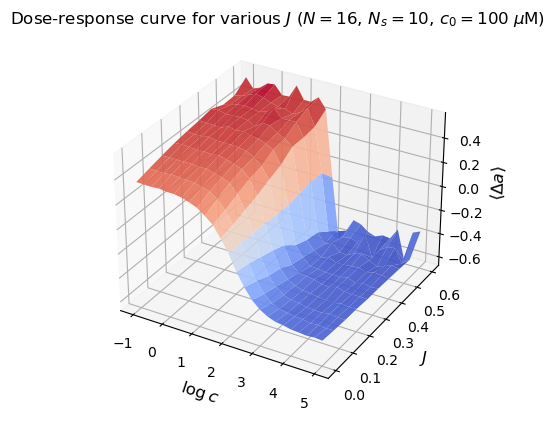

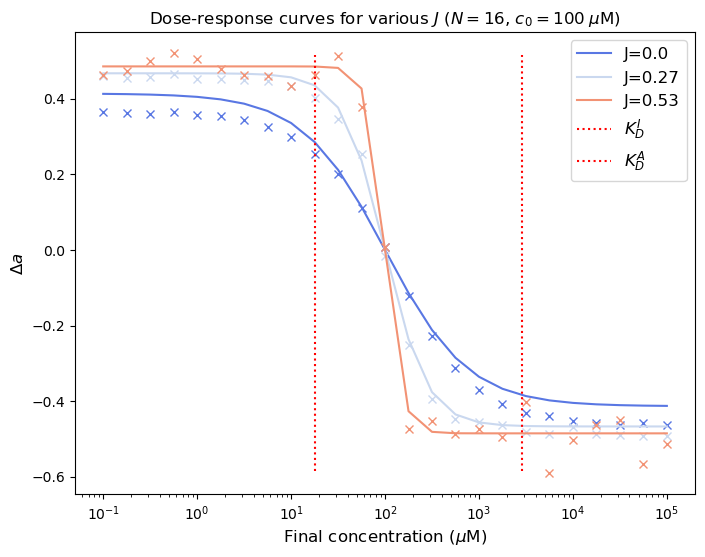

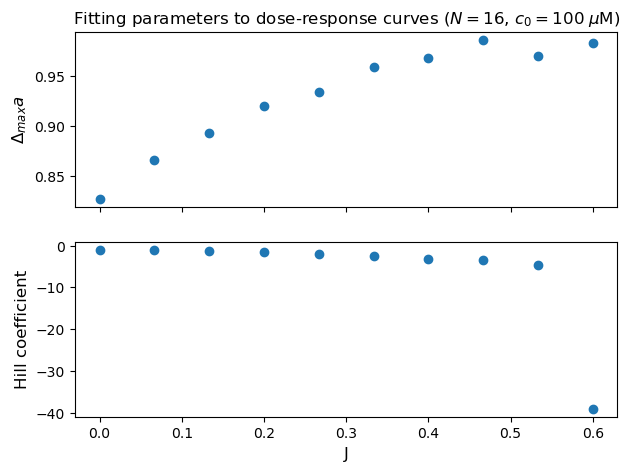

In [14]:
# define Hill function
def hill_func_max(conc,delta_a_max,nH):
    return delta_a_max*(conc**nH/(100**nH + conc**nH) - 0.5)        

# make a meshgrid for plotting
J_arr = np.linspace(0,0.6,10)
cnew_arr = np.logspace(-1,5,25)
J_plot, c_plot = np.meshgrid(J_arr,cnew_arr)

# parameters
n_samples = 10**1
n_steps = 5000
tf = 10**3
L = 4

# array to store fitting parameters and their variances
parm_arr = np.zeros((2,J_arr.size))
var_arr = np.zeros_like(parm_arr)

# extract dose-response curves
all_responses = dose_response_curve(n_samples,n_steps,tf,L,J_arr,cnew_arr)

# show results
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(np.log10(c_plot).T, J_plot.T, all_responses,cmap=plt.cm.coolwarm,alpha=0.9,label='Simulation')
ax.set_xlabel(r'$\log c$',size=12)
ax.set_ylabel('$J$',size=12)
ax.set_zlabel(r'$\langle \Delta a \rangle$',size=12)
ax.set_title(f'Dose-response curve for various $J$ ($N={L**2}, \, N_s={n_samples}$, $c_0=100 \; \mu$M)')
plt.show()

fig, ax = plt.subplots(1,1, figsize=(8,6))

# perform fitting
for j in range(J_arr.size):
    popt, pcov = curve_fit(hill_func_max,cnew_arr,all_responses[j,:],maxfev=5000)
    parm_arr[:,j] = popt
    var_arr[:,j] = [pcov[k,k] for k in range(2)]

    # visual inspection for some results
    if j % 4 == 0:
        ax.semilogx(cnew_arr,all_responses[j,:],'x')
        ax.semilogx(cnew_arr,hill_func_max(cnew_arr,*popt),label=f'J={np.round(J_arr[j],2)}')

#############
## Results ##
#############

# get a nice color map
colormap = matplotlib.colormaps.get_cmap('coolwarm')

# count the number of plots
ax = plt.gca()
lines = ax.lines
n_plots = len(lines)

# apply the same color to each pair of plots
for plot in range(0, n_plots, 2):
    # choose a colour
    random_color = colormap(plot/n_plots + 0.1)
    
    # colour the plots
    lines[plot].set_color(random_color)
    lines[plot+1].set_color(random_color)

# figure formatting
ax.axvline(x=18,ymin=0.05,ymax=0.95,label=r'$K_D^I$',linestyle=':',color='r')
ax.axvline(x=2900,ymin=0.05,ymax=0.95,label=r'$K_D^A$',linestyle=':',color='r')
ax.set_xlabel(r'Final concentration ($\mu$M)',size=12)
ax.set_ylabel(r'$\Delta a$',size=12)
ax.legend(fontsize=12)
ax.set_title(f'Dose-response curves for various $J$ ($N={L**2}$, $c_0=100 \; \mu$M)')
plt.show()

# show fitting parameters as functions of J
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(7,5),sharex=True)

ax1.plot(J_arr,-1*parm_arr[0,:],'o')
ax1.set_ylabel(r'$\Delta_{max} a$',size=12)
ax1.set_title(f'Fitting parameters to dose-response curves ($N=${L**2}, $c_0=100 \; \mu$M)')

ax2.plot(J_arr,-1*parm_arr[1,:],'o')
ax2.set_ylabel('Hill coefficient',size=12)
ax2.set_xlabel('J',size=12)

plt.show()

**Cosmetic problem**: the fitting tends to make $\Delta_{max} a$ negative, thus flipping the sign on $n_H$. Physically, this does not really change much, but it looks a bit strange...

#### Interpretation

WRITE THIS, but the maximum response does become stronger as $J$ increases

**REWRITE THIS**

### Interpretation for $\epsilon_0$ that is not chosen w.r.t. $c$

Interestingly, we find that for low coupling constants, the dose-response curve looks roughly like what we would expect for cooperative receptors. This makes sense, as we have implicitly built in this binding curve through the MWC-like free energy term. However, for larger $J$, the dose-response curve seems to shift up. Additionally, we note large fluctuations in the response for low concentrations. Apparently, at low concentrations, the free-energy term becomes weaker and receptors flip more randomly. This effect is amplified through coupling, as the random flip of one receptor may propagate to other receptors, causing fluctuations on a larger scale. 

These fluctuations appear to incresae with $J$, until at some point they rapidly die out. Additionally, the dose-response curve flattens out until the system hardly responds to concentration changes at all. This indicates that at high coupling constants, the receptors get 'stuck' in a confirmation where they are all in the same conformation. Even though the concentration changes drastically, the strong coupling makes activity-switches prohibitively costly, such that the system fails to respond to a change in concentration. 

We thus find two regimes based on the dose-response curve: a responsive (low $J$) and unresponsive regime (high $J$). Likely, this is another manifestation of the continuous phase transition we already observed. From a modelling perspective, these results already make clear that if our model is any good, we should take a low value for $J$. After all, real bacterial systems do respond to environmental changes, so we expect to see a sigmoidal dose-response curve.

### Interpretation for $\epsilon_0$ chosen w.r.t. $c$

Quick observations:
- larger $J$ means larger fluctuations, but also a steeper dose-response curve --> more cooperativity, which makes sense!
- fluctuations become more pronounced in the medium system, though the effect of $J$ on the cooperativity between receptors is similar for systems of all sizes considered. These fluctuations are less pronounced for the largest system considered
- amplitude of response also becomes higher for larger $J$. Should probably check whether this is also true for change in activity relative to baseline activity

Things to fix:
- look if there is a theoretical result available from classical Ising model
- perhaps look at relative response
- average over multiple simulations to make less noisy

## Estimating the Fundamental Flipping Frequency 

Thusfar, we have expressed time in the units of $\omega_0^{-1}$. In what follows, we would like to set some rate constants that have been measured experimentally, so we need an estimate for the time scale $\omega_0^{-1}$ to set these rate constants adequately. 

Keegstra et al. used finite-size scaling theory to estimate $\omega_0^{-1}$ for various values of $L$ and found a wide range: $\omega_0^{-1} = 15-35$ ms. Importantly, this result indicates that the fundamental time scale of the system depends on its size. Contrary to this approach, we will estimate $\omega_0^{-1}$ through a fitting procedure, as explained below. Phenomenologically, the response without adaptation has the form 

$$K^*(t) = G\left(1 - \exp\{-t/\tau_r\} \right), $$

for some gain $G$ and response time $\tau_2$. We have defined this response for $t \geq 0$ with the change in concentration at $t=0$. We use the star to distinguish this response kernel from the kernel $K(t)$ that Mattingly et al. use. Do note that we will normalise the activity by $\log(c_0/c_f)$.

One issue we have to overcome is that a priori, the response time may depend on $J$ and $L$. For this purpose, we quickly check whether this is true for a few values of $J$ and $L$ without doing any formal fitting. 

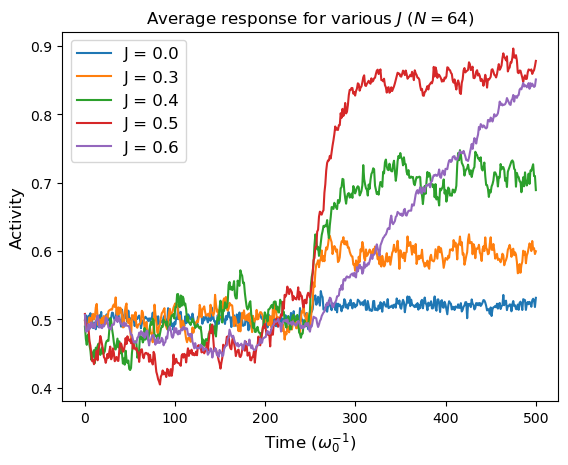

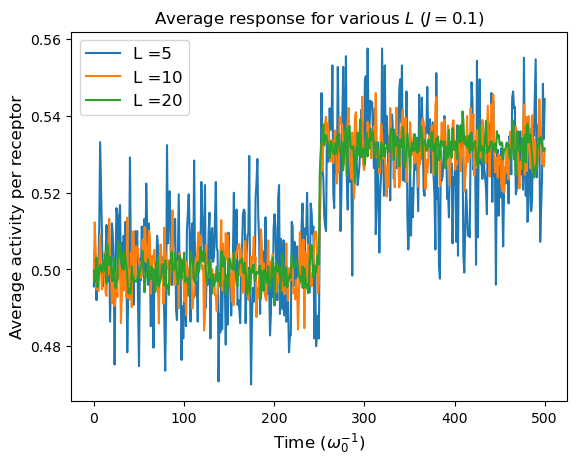

In [15]:
# obtain average response to a 10% decrease in concentration
n_samples = 10**2
n_steps = 500
tf = 500
L = 8

for J in [0.,0.3,0.4,0.5,0.6]:
    # obtain results
    all_states, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                                                              step_change=250,cbase=10**2,cnew=90)

    # convert to activity 
    ensemble_av_act = 0.5*(ensemble_av + 1)

    plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),label=f'J = {J}')

plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Activity',size=12)
plt.title(f'Average response for various $J$ ($N={L**2}$)')
plt.legend(fontsize=12)
plt.show()

# obtain response for various L
J = 0.1

for L in [5,10,20]:
    # obtain results
    all_states, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                                                              step_change=250,cbase=10**2,cnew=90)

    # convert to activity 
    ensemble_av_act = 0.5*(ensemble_av + 1)

    plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),label=f'L ={L}')

plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Average activity per receptor',size=12)
plt.title(f'Average response for various $L$ ($J={J}$)')
plt.legend(fontsize=12)
plt.show()

**Problem**: the above results are nice in that they (i) hint at a phase transition in $J$ by looking at the response and (ii) show that bove the response amplitude and response time depend on $J$. Intuitively, this makes a lot of sense in the framework of the Ising model. 

However, it makes estimating $\omega_0$ difficult, because I would have to simultaneously fit the response time over $J$ and $\omega_0$. Actually, I suspect that $L$ also has an effect (i.e., a change propagates more slowly in a larger system), so this makes the task of finding an ideal combination of these parameters for the response time daunting. If I had a model for the response kernel in terms of $J$ and $L$, it would be no problem, but I don't have that...

Even more so, my tentative results suggest that the response time does not depend on $L$, but this disagrees with the results by Fotis, so what to do?

### Interpretation
The above results indicate that the coupling constant $J$ has a strong effect, both on the gain and response time. In contrast, a larger value of $L$ only appears to reduce the fluctuations in the average activity, though the gain and response time seem largely independent of $L$. For now, we thus assume that we can keep $L$ at a constant value (say, 10), whilst we have to systematically vary $J$ when fitting the response kernel. 

Concretely, we maintain the following approach. For various values of $J$, we simulate the system to get an ensemble-averaged response to a 10% concentration decrease (i.e., $c_0 = 100 \, \mu$M and $c_f = 90 \, \mu$M). We administer the stimulus only after some time to let the system equilibrate. We then extract the response by shifting time to the time the stimulus is presented and shifting the activity down by its value right before the stimulus is presented. Finally, we rescale by $\log(c_0/c_f)$ and perform fitting to estimate $\tau_r$ and $G$ for a given value of $J$.

**To do**: think more thoroughly about the fitting protocol. Perhaps using a bayesian approach is a bit neater, for example by fitting to each 'raw' response and then getting a distribution on $G$ and $\tau_r$, or perhaps using bootstrapping in some way or another. Check the notes for Statistical Methods again

In [ ]:
# define the model function
def Kstar(t,G,tau_r):
    # make sure encoded in 64 bits to avoid errors
    x = np.float64(-t/tau_r)
    return G*(1-np.exp(x))

# parameters
n_samples = 10**2
n_steps = 10**3
step_change = n_steps//4
tf = 10**4
L = 8

# values of J to scan over
J_arr = np.linspace(0.,0.7,10)

# arrays to store fitted parameters and error bars
parm_arr = np.zeros((2,J_arr.size))
sd_arr = np.zeros_like(parm_arr)

# loop over all values of J
for i,J in enumerate(J_arr):
    # obtain data
    _, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                                                              step_change=step_change,cbase=10**2,cnew=90)

    # transform to activity
    activity = np.mean(0.5*(ensemble_av + 1),axis=(1,2))

    # find response and shift time
    shifted_activity = activity[step_change-1:] - activity[step_change-1]
    response = shifted_activity/np.log(100/90)
    shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

    # perform fitting and store results
    popt, pcov = curve_fit(Kstar,shifted_time,response)
    print(popt)
    parm_arr[:,i] = popt
    sd_arr[:,i] = [np.sqrt(pcov[j,j]) for j in range(2)]

    # visual check for a few values
    if i % 3 == 0:
        plt.plot(shifted_time,response,label=f'J={np.round(J,2)}')
        plt.plot(shifted_time,Kstar(shifted_time,*popt))

plt.xlabel(r'Time $(\omega_0^{-1})$')
plt.ylabel('Response')
plt.legend()
plt.show()

# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

# show how the fitting parameters depend on J
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

for i,ax in enumerate((ax1, ax2)):
    ax.set_xlabel(r'$J$')
    ax.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,linestyle=':',color='r')
    
ax1.plot(J_arr,parm_arr[0,:],'o')
ax1.fill_between(J_arr,1.70,1.76,alpha=0.2)
ax1.set_ylabel(r'$G$')
ax1.set_title(f'Dependence of gain $G$ on $J$ ($L={L}, N_s={n_samples}$)')

ax2.semilogy(J_arr,parm_arr[1,:],'o')
ax2.set_ylabel(r'$\tau_r \; (\omega_0^{-1})$')
ax2.set_title(f'Dependence of response time on $J$ ($L={L}, N_s={n_samples}$)')

plt.show()

/tmp/ipykernel_489190/1255007338.py:5: RuntimeWarning: overflow encountered in exp
  return G*(1-np.exp(x))


[0.20773555 0.31130836]


Observations for supercritical $J$:
- at some point ($J\sim 0.6$), the response seems to be 'ragged', so settles on plateau, but then increases again, settles, and increases again
- these plateaus become longer for higher $J$
- the problem is that this makes it hard to judge whether the system actually responds. I guess the simulation would have to be infinitely long to actually measure the response time. However, I question whether we can actually attribute these plateaus to the changing concentration. For all I know, they may just reflect spontaneous activity switches. Then again, I don't observe the plateaus going downward, so they likely do reflect the response of the system...
- the risk of using short simulation times is that if the response remains constant for a long time, then the fitting will give a very short response time, while in reality, the system responds almost infinitely slowly
- by the way, for subcritical values of $J$, I don't observe these plateaus

Conclusion: run the simulations awfully long, at least for supercritical $J$.

**TO DO:** run the simulations very long and change plot to log of $\tau_r$ (possible with error bars?)

Observations as of 10/11/2023:
- running the simulation for a very long time does show that the response time increases (apparently) indefinitely as $J$ increases (for $J=0.8$, I measure that $\tau_r \sim 10^4$, which is at the ceiling of the simulation time)
- the gain does seem to decrease, though I can imagine that if we truly ran the program infinitely long, then $G$ would always reach more or less the same value, because eventually, the spins will respond, but it just takes infinitely long for large $J$
- in any case, I think this gives already more confidence in choosing a subcritical $J$, just because a supercritical $J$ would lead to unphysical results

### Interpretation

Even though we used only a few values of $J$, these are already some pretty informative results. They show explicitly that $G$ and $\tau_r$ depend strongly on $J$, where $\tau_r$ can even span multiple orders of magnitude. This dependence shows an interesting behaviour with a neat physical interpretation. 

For this purpose, we plotted the approximate theoretical value of the coupling strength (red dashed line). In an infinite system, an exact result is available for a 2d system,

$$ J^* = \frac{1}{2}\log(1 + \sqrt{2}). $$

In a finite square lattice, no exact result is known, but an expression for a lattice of size $L^2$, an approximate result is

$$J^*_L \approx \frac{J^*}{1 - 1.25/L}, $$

where the value of 1.25 comes from having an open boundary condition. With this value at hand, we can make sense of the current results. As $J$ increases towards $J^*_L$, both $G$ and $\tau_r$ increase, until they reach a peak around this critical value and then decrease again as $J$ further increases. While we do not find that these peaks perfectly align with $J^*_L$, we conjecture that this is because we use relatively few values of $J$ for these results. 

We can make physical sense of this behaviour. The gain $G$ is a measure for the response strength to an environmental stimulus, and $\tau_r$ measures how fast the system responds. For low coupling strength, the receptors act largely independent of each other. As such, even though the concentration change may affect the activity of individual receptors, nothing forces the receptors to adjust their activity together, so some receptors may not flip. This results in a low response amplitude. Simultaneously, due to the weak coupling, individual receptors hardly depend on the activity of other receptors, such that they can mount an individual response quickly. This explains the short response time. 

As $J$ approaches the critical value, the receptors become more cooperative. That means that if an environmental stimulus changes the activity of some receptors, the energetic cost of having neighbours with a different activity status becomes high. As a result, more receptors flip their activity. As such, the units change their activity in unison, leading to a stronger gain $G$. Still, it takes some time for the initial response of some receptors to propagate to other receptors. Additionally, for strongly coupled receptors, an environmental stimulus may provoke a response less quickly, because the receptors are 'frozen' through the high coupling to their neighbours. These effects cause the response time to increase drastically as the coupling approaches a critical value. 

For supercritical values of $J$, we contend that the receptors become 'frozen in motion'. That is, the strong coupling makes the energetic cost of flipping an individual spin almost prohibitively high. A concentration change will thus hardly provoke any response, leading to a strong drop in $G$. We contest that the subsequent decrease in $\tau_r$ is an artefact of the fitting procedure. After all, for a (nearly) constant activity, a short value of $\tau_r$ leads to a good fit. Physically, however, the system hardly responds, so we would contest that the response time actually increases. **IS THIS A FAIR INTERPRETATION?** 

With this physical insight at hand, we return to the issue of estimating $\omega_0$. For this, we use the experimental result by Mattingly et al., who estimated the fitting parameters as $G = 1.73 \pm 0.03$ and $\tau_r = 0.22 \pm 0.01$ s. Do note that they extracted these values from adaptive cells and using a different kernel, so we should use these values with care in this part of the project. Still, they give a good reference for us to estimate $\omega_0$. The idea is that using the measured value of $G$, we can place a constraint on $J$ from our fitting procedure. Once we have reasonable values for $J$, we can use these to estimate $\tau_r$ in units of $\omega_0^{-1}$ from our fitting procedure. Comparing our estimate to the value found by Mattingly et al. then allows us to estimate the time scale $\omega_0^{-1}$. 

For this purpose, we perform a finer grid search, while keeping the basic approach the same. After some further test, our above result indicate that for $G$ between 1.70 and 1.76, $J$ should be somewhere between 0.3 and 0.35. **Problem: are there any good a priori reasons to ignore the supercritical regime? I would argue that in this case, the cell cannot really respond, but the above results do not allow me to actually draw this conclusion, so what to do?** Therefore, we use these as bounds to get a finer sense of what a correct value of $J$ would be. 

In [13]:
# function for averaging over two axes
@numba.jit(nopython=True)
def lattice_mean(lattice):
    return np.sum(np.sum(lattice[:,:,:],axis=-1),axis=-1)/lattice[0,:,:].size

# define the model function
def Kstar(t,G,tau_r):
    # make sure encoded in 64 bits to avoid errors
    x = np.float64(-t/tau_r)
    return G*(1-np.exp(x))

# model for a basic linear regression
def lin_fit(x,a,b):
    return a + b*x

# function for estimating omega0
def omega0_estimator(n_samples,n_steps,step_change,tf,L,J_arr,plots_bool=True):
    
    #####################
    ## Data collection ##
    #####################
    
    # arrays to store fitted parameters and error bars
    parm_arr = np.zeros((2,J_arr.size))
    sd_arr = np.zeros_like(parm_arr)

    if plots_bool:
        # prepare figure and get a nice color map
        fig, ax = plt.subplots(1, 1, figsize=(7,4))
        colormap = matplotlib.colormaps.get_cmap('coolwarm')

    # loop over all values of J
    for i,J in enumerate(J_arr):
        # obtain data
        _, ensemble_av, t_grid = ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                                                                  step_change=step_change,cbase=10**2,cnew=90)

        # transform to activity
        activity = lattice_mean(0.5*(ensemble_av + 1))

        # find response and shift time
        shifted_activity = activity[step_change-1:] - activity[step_change-1]
        response = shifted_activity/np.log(100/90)
        shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

        # perform fitting and store results
        popt, pcov = curve_fit(Kstar,shifted_time,response)
        parm_arr[:,i] = popt
        sd_arr[:,i] = [np.sqrt(pcov[j,j]) for j in range(2)]

        # visual check; only if desired
        if plots_bool:
            ax.plot(shifted_time,response,label=f'$J={np.round(J,2)}$',color=colormap(i/J_arr.size))

    if plots_bool:
        # formatting
        ax.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
        ax.set_ylabel('Response kernel',size=12)
        ax.set_title(f'Response kernels for various $J$ $(L={L},\, N_s={n_samples})$')

        # code for placing legend next to figure
        lgnd = ax.get_position()
        ax.set_position([lgnd.x0, lgnd.y0, lgnd.width * 0.9, lgnd.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.show()

    ########################
    ## Linear regressions ##
    ########################

    # regress J on G
    popt_GJ, pcov_GJ = curve_fit(lin_fit,parm_arr[0,:],J_arr)

    # regress tau on J
    popt_Jtau, pcov_Jtau = curve_fit(lin_fit,J_arr,np.log10(parm_arr[1,:]))

    # regress tau on G
    popt_Gtau, pcov_Gtau = curve_fit(lin_fit,parm_arr[0,:],np.log10(parm_arr[1,:]))
    
    if plots_bool:
        # show results of fitting procedure
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,4))

        ax1.plot(parm_arr[0,:],J_arr,'o')
        ax1.plot(parm_arr[0,:],lin_fit(parm_arr[0,:],*popt_GJ))
        ax1.set_xlabel(r'$G$',size=12)
        ax1.set_ylabel(r'$J$',size=12)
        ax1.fill_betweenx([J_arr[0],J_arr[-1]],1.70,1.76,alpha=0.3)

        ax2.plot(J_arr,np.log10(parm_arr[1,:]),'o')
        ax2.plot(J_arr,lin_fit(J_arr,*popt_Jtau))
        ax2.set_xlabel(r'$J$',size=12)
        ax2.set_ylabel(r'$\log \tau_r$',size=12)

        ax3.plot(parm_arr[0,:],np.log10(parm_arr[1,:]),'o')
        ax3.plot(parm_arr[0,:],lin_fit(parm_arr[0,:],*popt_Gtau))
        ax3.set_xlabel(r'$G$',size=12)
        ax3.set_ylabel(r'$\log \tau_r$',size=12)
        ax3.fill_betweenx([np.min(np.log10(parm_arr[1,:])),np.max(np.log10(parm_arr[1,:]))],1.70,1.76,alpha=0.3)

        plt.show()

    # get point estimates
    Jest = lin_fit(1.73,*popt_GJ)
    
    if plots_bool:
        print('Estimate of J:', Jest)
        print('Estimate of tau_r via J:', 10**lin_fit(Jest,*popt_Jtau))
        print('   Estimate of omega0 in 1/s for tau_r=1/60 s:', 10**lin_fit(Jest,*popt_Jtau)/(1/60))
        print('   Estimate of omega0 in 1/s for tau_r=0.1 s:', 10**lin_fit(Jest,*popt_Jtau)/0.1)
        print('Estimate of tau_r via G:', 10**lin_fit(1.73,*popt_Gtau))
        print('   Estimate of omega0 in 1/s for tau_r=1/60 s:', 10**lin_fit(1.73,*popt_Gtau)/(1/60))
        print('   Estimate of omega0 in 1/s for tau_r=0.1 s:', 10**lin_fit(1.73,*popt_Gtau)/0.1)
    
    # return the estimates for J and omega0; we take the value estimated via G with taur = 100 ms
    return Jest, 10**lin_fit(1.73,*popt_Gtau)/0.1

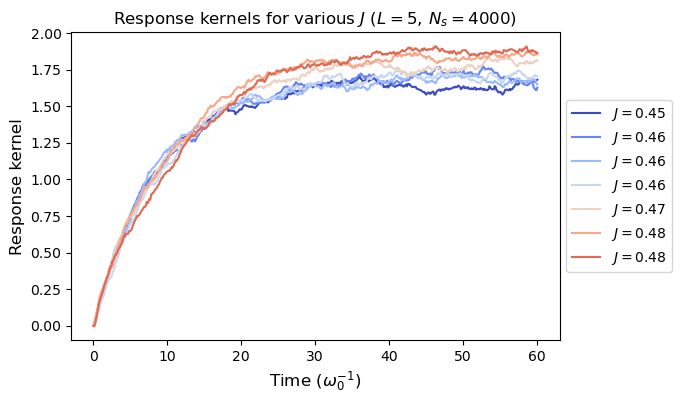

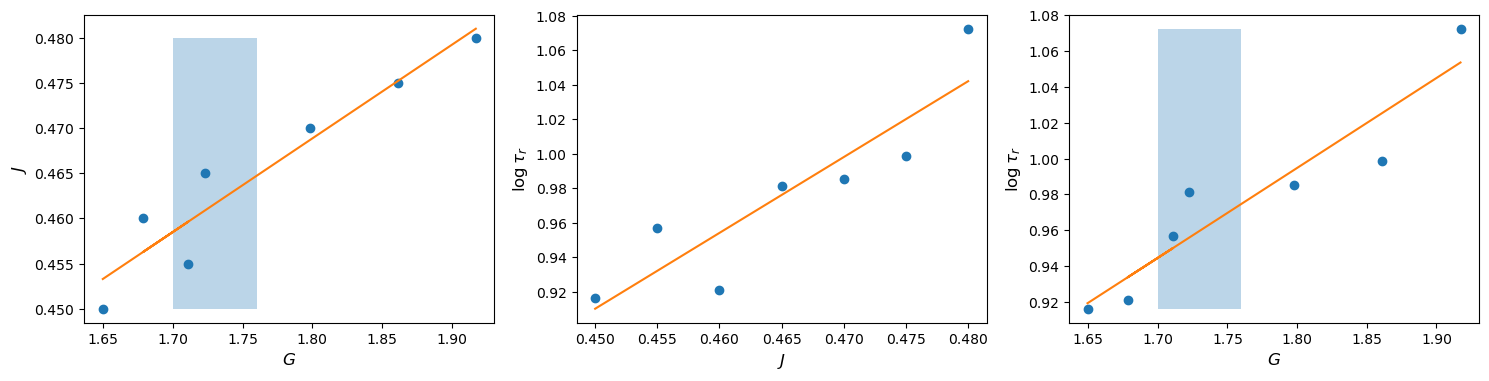

Estimate of J: 0.4616238188010352
Estimate of tau_r via J: 0.96120526326044
   Estimate of omega0 in 1/s for tau_r=1/60 s: 548.727231914936
   Estimate of omega0 in 1/s for tau_r=0.1 s: 91.45453865248933
Estimate of tau_r via G: 0.959710483726539
   Estimate of omega0 in 1/s for tau_r=1/60 s: 546.8418377010925
   Estimate of omega0 in 1/s for tau_r=0.1 s: 91.1403062835154
Progress: 14.29 %


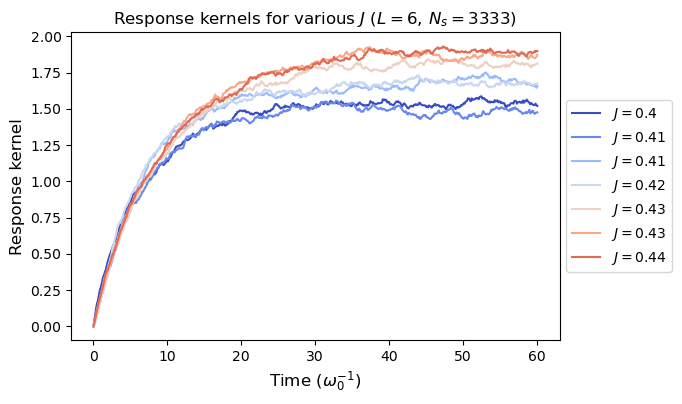

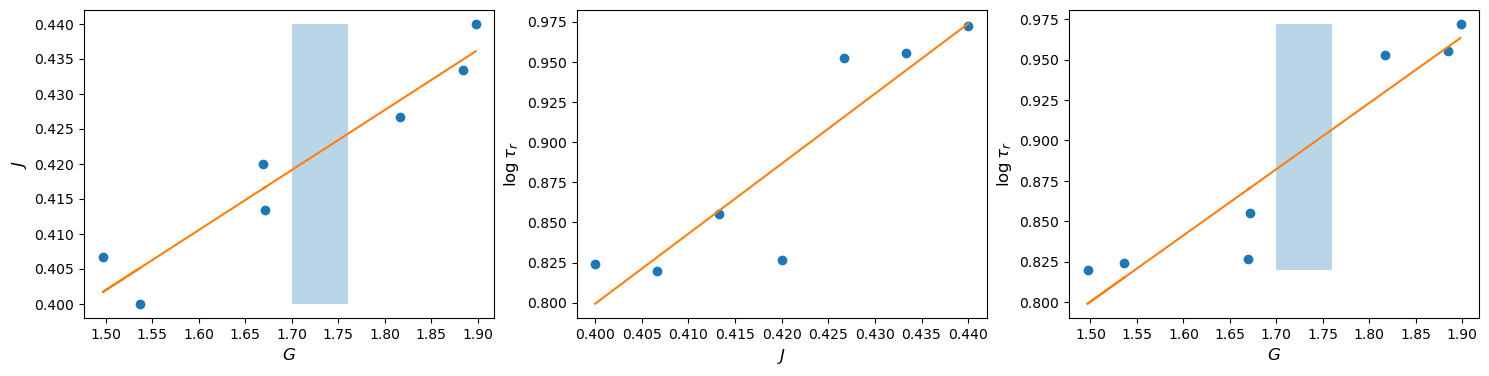

Estimate of J: 0.421668137182799
Estimate of tau_r via J: 0.8937979944772626
   Estimate of omega0 in 1/s for tau_r=1/60 s: 469.8391962168125
   Estimate of omega0 in 1/s for tau_r=0.1 s: 78.30653270280209
Estimate of tau_r via G: 0.8945039709618973
   Estimate of omega0 in 1/s for tau_r=1/60 s: 470.6035742627777
   Estimate of omega0 in 1/s for tau_r=0.1 s: 78.43392904379628
Progress: 28.57 %


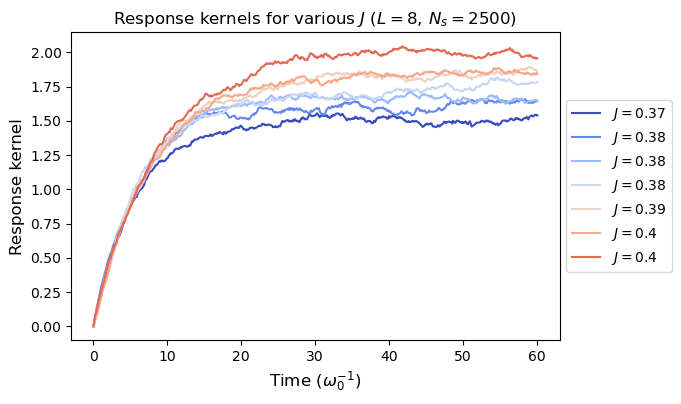

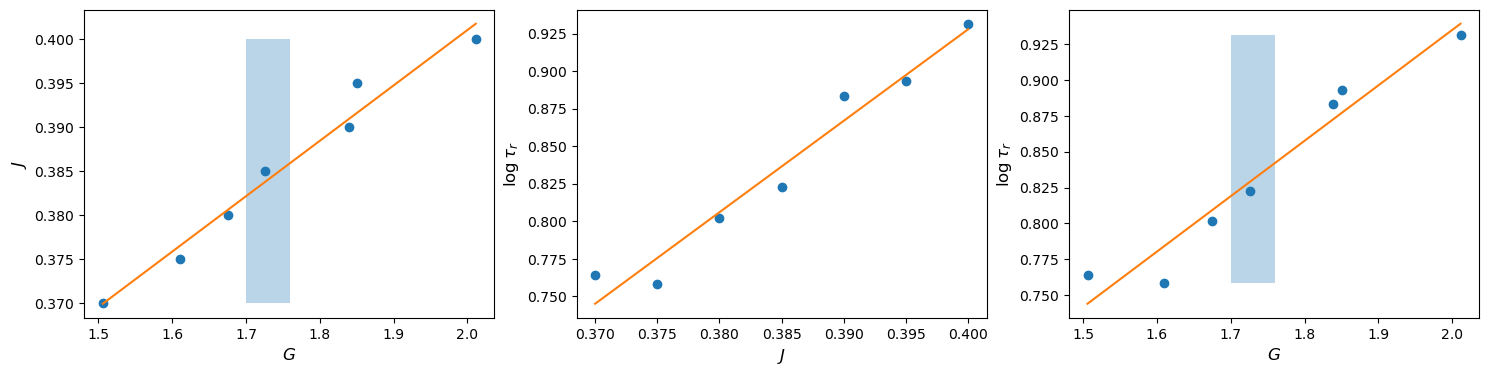

Estimate of J: 0.3840346269676851
Estimate of tau_r via J: 0.8305826316604084
   Estimate of omega0 in 1/s for tau_r=1/60 s: 406.19435354924826
   Estimate of omega0 in 1/s for tau_r=0.1 s: 67.6990589248747
Estimate of tau_r via G: 0.8305492536423995
   Estimate of omega0 in 1/s for tau_r=1/60 s: 406.16313638664866
   Estimate of omega0 in 1/s for tau_r=0.1 s: 67.69385606444143
Progress: 42.86 %


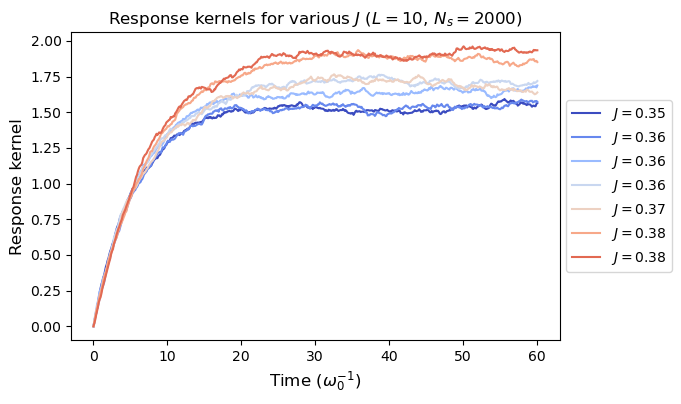

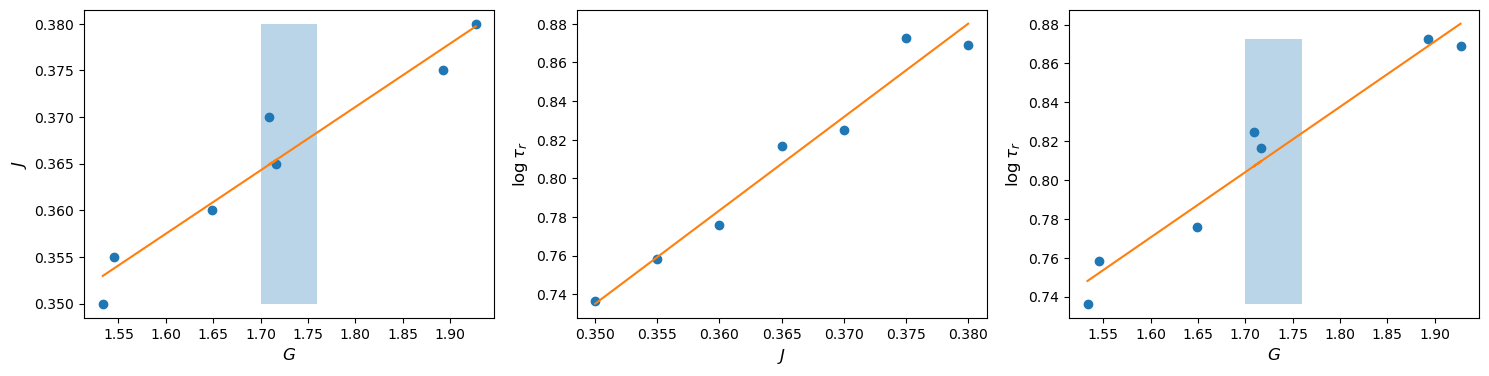

Estimate of J: 0.3663225499253218
Estimate of tau_r via J: 0.8139793016841941
   Estimate of omega0 in 1/s for tau_r=1/60 s: 390.95840305830507
   Estimate of omega0 in 1/s for tau_r=0.1 s: 65.15973384305084
Estimate of tau_r via G: 0.814141101846475
   Estimate of omega0 in 1/s for tau_r=1/60 s: 391.10408512578596
   Estimate of omega0 in 1/s for tau_r=0.1 s: 65.18401418763098
Progress: 57.14 %


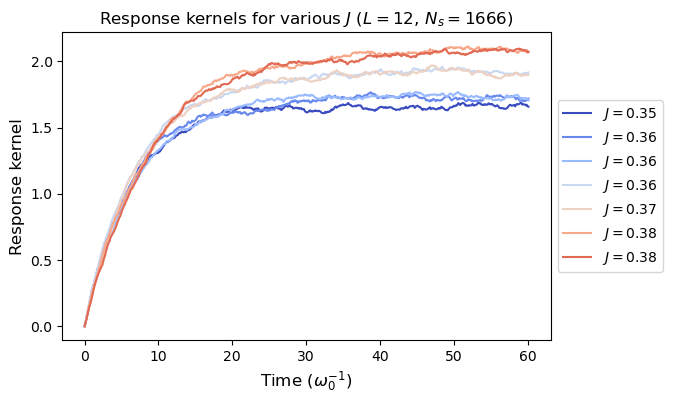

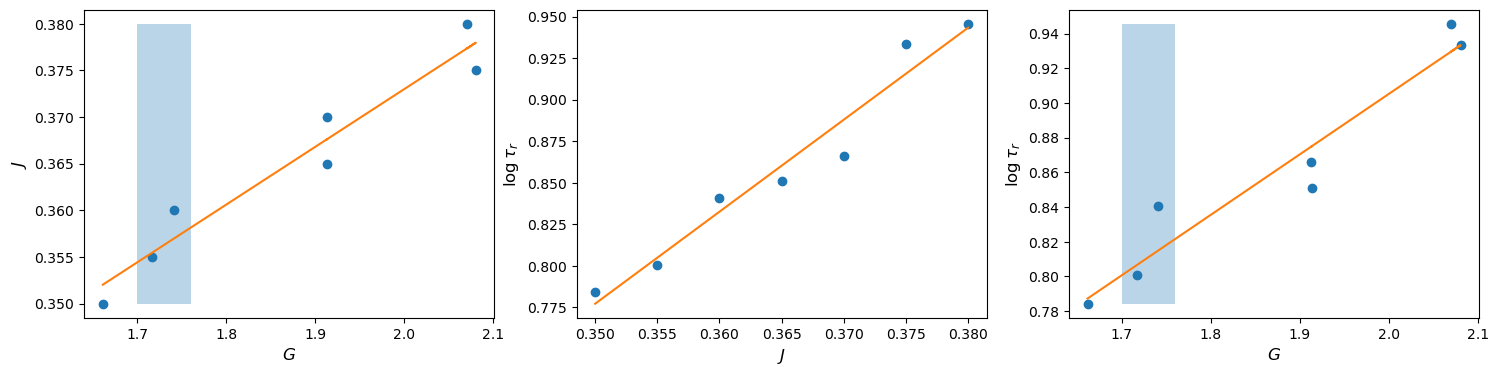

Estimate of J: 0.35628323544525325
Estimate of tau_r via J: 0.8119822619260717
   Estimate of omega0 in 1/s for tau_r=1/60 s: 389.1647649826014
   Estimate of omega0 in 1/s for tau_r=0.1 s: 64.8607941637669
Estimate of tau_r via G: 0.8111568116361212
   Estimate of omega0 in 1/s for tau_r=1/60 s: 388.425793863029
   Estimate of omega0 in 1/s for tau_r=0.1 s: 64.73763231050484
Progress: 71.43 %


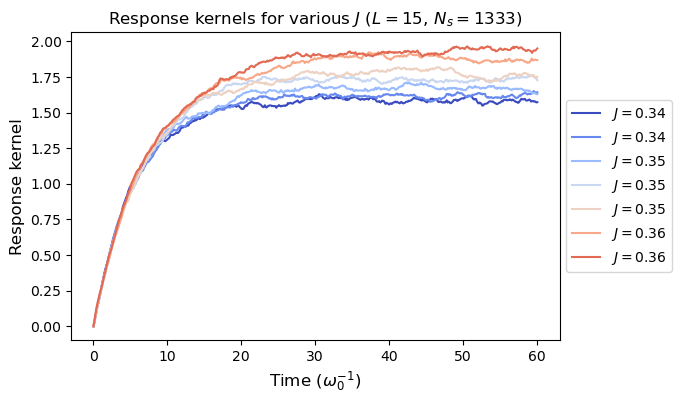

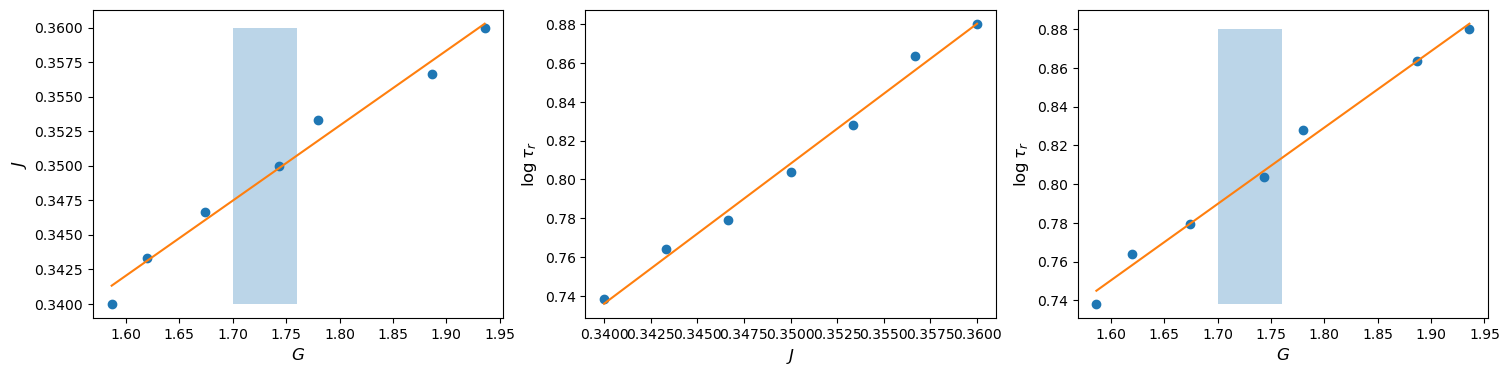

Estimate of J: 0.34909898569396325
Estimate of tau_r via J: 0.8016110040925493
   Estimate of omega0 in 1/s for tau_r=1/60 s: 379.98132646279373
   Estimate of omega0 in 1/s for tau_r=0.1 s: 63.330221077132286
Estimate of tau_r via G: 0.8015563715928913
   Estimate of omega0 in 1/s for tau_r=1/60 s: 379.93352934611914
   Estimate of omega0 in 1/s for tau_r=0.1 s: 63.32225489101985
Progress: 85.71 %


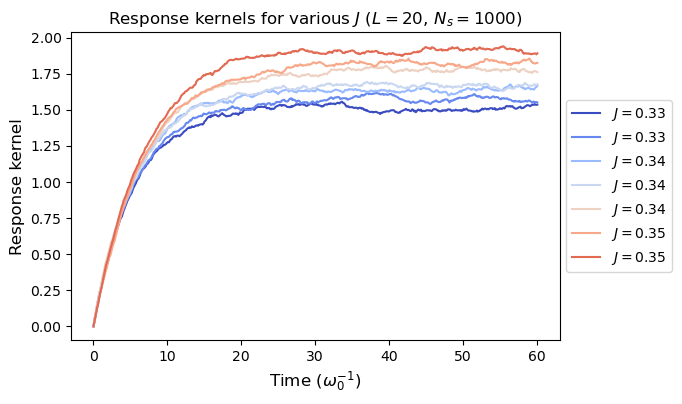

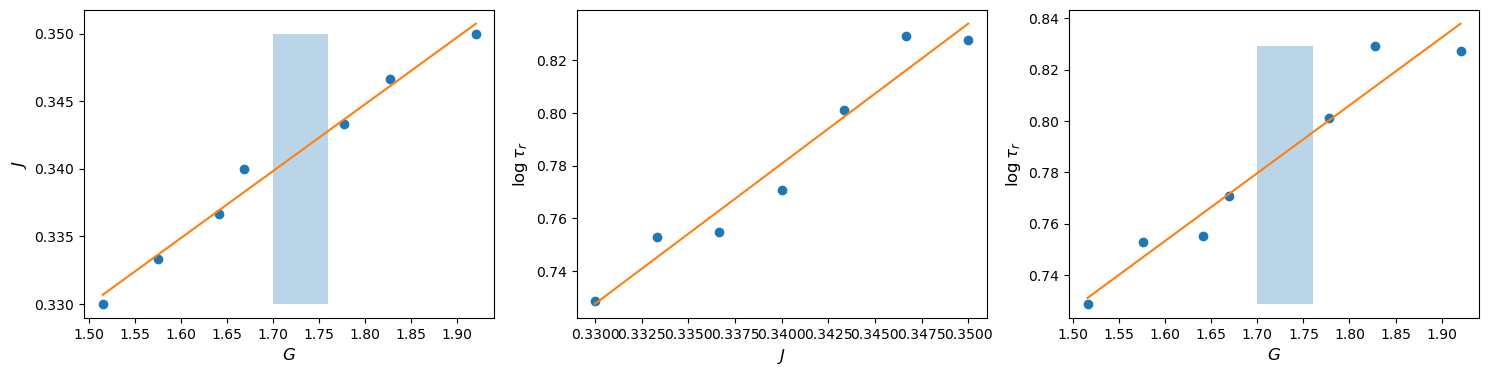

Estimate of J: 0.3412953840155378
Estimate of tau_r via J: 0.787575361910891
   Estimate of omega0 in 1/s for tau_r=1/60 s: 367.8973099459241
   Estimate of omega0 in 1/s for tau_r=0.1 s: 61.31621832432069
Estimate of tau_r via G: 0.7876086759162331
   Estimate of omega0 in 1/s for tau_r=1/60 s: 367.9255318173625
   Estimate of omega0 in 1/s for tau_r=0.1 s: 61.320921969560416
Progress: 100.0 %


In [58]:
# estimate J and omega0 for various L

# parameters
L_arr = np.array([5,6,8,10,12,15,20])
n_steps = 750
step_change = n_steps//3
tf = 90
Jmin_arr = np.array([0.45,0.40,0.37,0.35,0.35,0.34,0.33])
Jmax_arr = np.array([0.48,0.44,0.40,0.38,0.38,0.36,0.35])

# arrays to store results
J_est = np.zeros_like(L_arr,dtype='float32')
omega0_est = np.zeros_like(L_arr,dtype='float32')

for i,L in enumerate(L_arr):
    # set sample size and array of J_values
    n_samples = 2*10**4//L
    J_arr = np.linspace(Jmin_arr[i],Jmax_arr[i],7)
    
    # obtain estimates
    J_est[i], omega0_est[i] = omega0_estimator(n_samples,n_steps,step_change,tf,L,J_arr,plots_bool=True)

    # print progress
    print('Progress:',np.round(100*(i+1)/L_arr.size,2),'%')

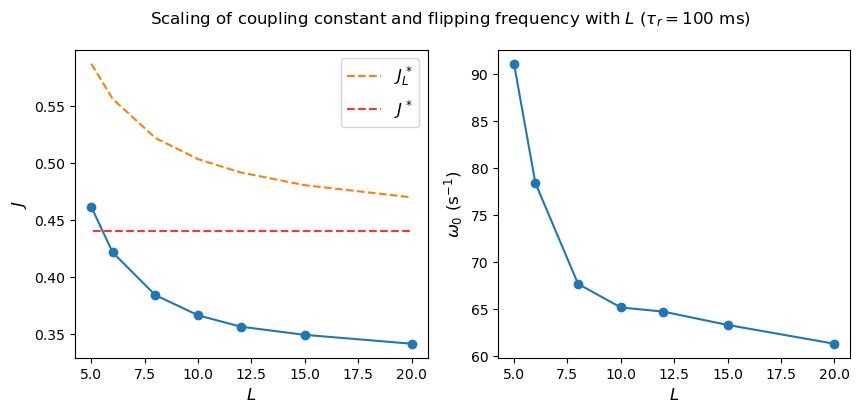

In [73]:
# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L_arr)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharex=True)
fig.suptitle(r'Scaling of coupling constant and flipping frequency with $L$ ($\tau_r = 100$ ms)')

ax1.plot(L_arr, J_est,'o-')
ax1.plot(L_arr, J_crit_fin,'--',label=r'$J^*_L$')
ax1.axhline(y=J_crit_inf,xmin=0.05,xmax=0.95,label=r'$J^*$',color='r',linestyle='--',alpha=0.8)
ax1.legend(fontsize=12)
ax1.set_ylabel(f'$J$',size=12)
ax1.set_xlabel(f'$L$',size=12)

ax2.plot(L_arr, omega0_est,'o-')
ax2.set_ylabel(r'$\omega_0$ (s$^{-1}$)',size=12)
ax2.set_xlabel(f'$L$',size=12)

plt.show()

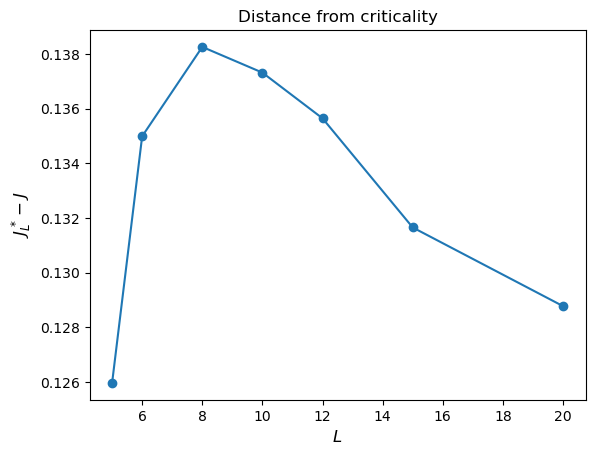

In [65]:
plt.plot(L_arr,J_crit_fin-J_est,'-o')
plt.title('Distance from criticality')
plt.xlabel(r'$L$',size=12)
plt.ylabel(r'$J_L^*-J$',size=12)
plt.show()

## Interpretation

Insisting that the cell reaches a gain of 1.73, we find that it should be tuned subcritically for all lattice sizes studied. In fact, the corresponding coupling constants are between roughly $0.126$ and $0.138$ away from their critical value. This is a relatively narrow range, so it seems to be the case that the cell is tuned to a rather specific subcritical regime. Intuitively, a subcritical regime seems to leverage response strength and time, since the latter increases almost exponentially with $J$. As such, even though a larger coupling increases the gain, at some point this becomes too costly in terms of response time. Ostensibly, being at a rather specific distance away from criticality balances these opposing considerations.

**TO DO**: add values from the results from the cluster and maybe do a few more values of $L$, just to establish that the curves we're showing are nice and smooth, but they look promising!

### Interpretation

Results here and from the cluster indicate that if we take $\tau_r  =100$ ms, then the value of $\omega_0$ ranges roughly between **50 and 58 ms**. We note that for larger $L$, the value of $\omega_0^{-1}$ appears to decrease. This is because the value of $J$ at which we achieve a large enough gain is lower in a lower system. A possible interpretation is that the critical value $J_L^*$ decreases as $L$ increases. As such, a larger system reaches a critical regime for lower values of $J$. Since the gain appears to increase as the system is closer to criticality, this would explain why we find lower values of $J$ for larger $L$, which results in a lower estimate for $\omega_0$. 

**REWRITE**

Based on these results, we estimate that in order to have our estimate of $G$ agree with that of Mattingly et al., we take $J\approx 0.34$ and $\tau_r \approx 5.5 \, \omega_0^{-1}$. Given that Mattingly et al. measured $\tau_r = 0.22$ s, we can thus find that $\omega_0 = 5.5/0.22 = 25$ s$^{-1}$. This leads us to conclude that the fundamental activity-switching time scale is $\boxed{\omega_0^{-1} = 40 \, \text{ms}}$. 

The order of magnitude of this result is close to what Keegstra et al. found (i.e., $\omega_0^{-1} = 15-35$ ms), so this provides some support in favour of our approach. It is remarkable that whilst these researchers varied $L$ to get an estimate of this time scale, we found that the effect of $L$ is negligible compared to the effect of $J$. A priori, it is not obvious that these two approaches should yield similar results. Our interpretation of this is that both estimates point to a similar physical truth, because despite their differences, both method yield akin results. 

An additional corollary of this part is that we have found an estimate of $J$, which is a subcritical value. This agrees with Keegstra et al.'s observation that the chemotaxis receptor array is near-critical. Still, our results suggest that the receptors are further away from criticality than what their research suggested. 

A physical explanation as to why the system should be near-critical is that being close to the critical coupling strength comes at both a benefit and a cost. On the one hand, the gain is high at criticality, making the cell sensitive to environmental changes. On the other hand, cooperativity comes at the cost of responding slowly to concentration changes. It seems reasonable that *E. coli* leverages these competing effects, such that the coupling strength is close to being critical.

## Noise without Methylation


In [6]:
@numba.jit(nopython=True)
# function for averaging over two axes
def lattice_mean(lattice):
    return np.sum(np.sum(lattice[:,:,:],axis=-1),axis=-1)/lattice[0,:,:].size

@numba.jit(nopython=True)
# function for finding several realisations of single-cell activity
def activity_finder_nometh(n_steps,tf,n_samples,Nc,L,J):
    # array to save results
    all_act = np.zeros((n_steps,n_samples))
    
    for sample in range(n_samples):
        # obtain a realisation
        _, cell_av, time = ensemble_averaged_ising(Nc,n_steps,tf,L,J)
        
        # extract activity
        all_act[:,sample] = 0.5*(lattice_mean(cell_av) + 1)
        
    return all_act, time

def autocorr(all_act,time,co):   
    # obtain average of product 
    ata0_av = np.mean(all_act[co:,:]*all_act[co,:],axis=1)
    
    # obtain factors for product of averages
    at_av = np.mean(all_act[co:,:],axis=1)
    a0_av = np.mean(all_act[co,:])
    
    # shift time
    time_s = time[co:] - time[co]
    
    # return the autocorrelator: average of product minus product of averages
    return ata0_av-at_av*a0_av, time_s

Parameters of best fit: [amp, tau_n] = [4.31476609e-05 3.37244538e-01]


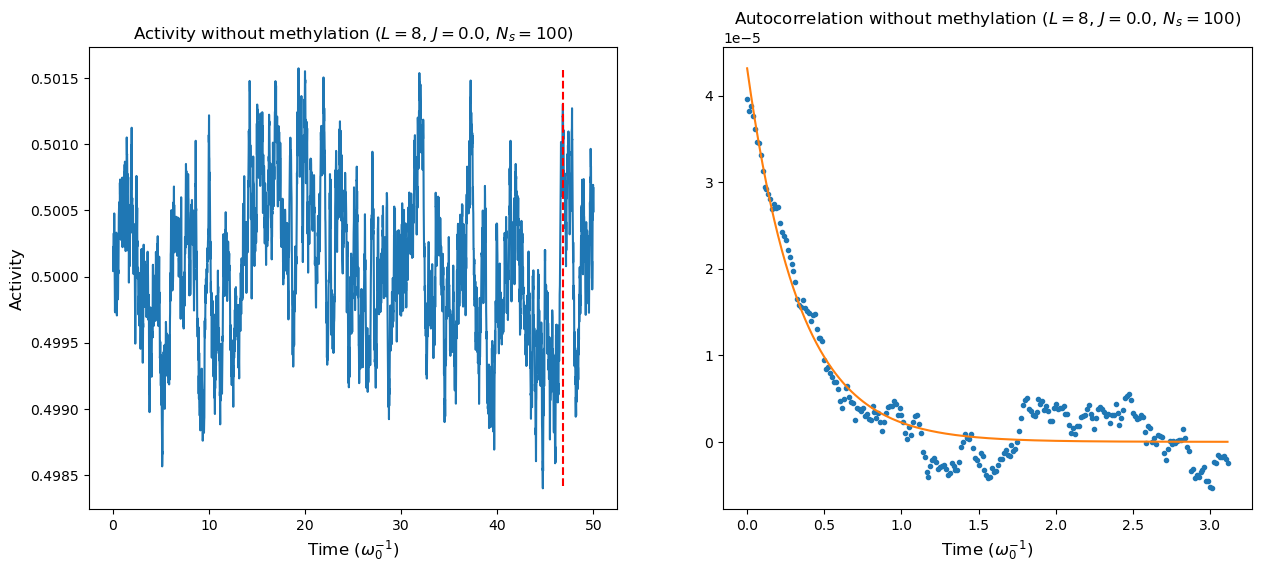

In [9]:
# time-related parameters
n_steps = 4000
tf = 50
co = 3750

# cluster-related parameters
n_samples = 100
Nc = 1
L = 8
J = 0.

# obtain activities
all_act, time = activity_finder_nometh(n_steps,tf,n_samples,Nc,L,J)

# obtain autocorrelation
auto_corr, time_s = autocorr(all_act,time,co)

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

ax1.plot(time,np.mean(all_act,axis=1))
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.set_title(f'Activity without methylation $(L={L},\, J={J},\, N_s={n_samples})$')
ax1.axvline(x=tf*co/n_steps,ymin=0.05,ymax=0.95,color='r',linestyle='--')

# fit an exponential 
def noise_nometh(t,amp,tau_n):
    return amp*np.exp(-t/tau_n)

popt, pcov = curve_fit(noise_nometh,time_s,auto_corr)

# show the data with fit
print('Parameters of best fit: [amp, tau_n] =', popt)

ax2.plot(time_s,auto_corr,'.')
ax2.plot(time_s,noise_nometh(time_s,*popt))
ax2.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax2.set_title(f'Autocorrelation without methylation $(L={L},\, J ={J},\, N_s={n_samples})$')

plt.show()

## Feedback Through (De)methylation

So far, it seems that we have incorporated the effect of the ligand concentration well, because the system shows cooperativity whilst retaining some desirable features of the Ising model, such as a continuous phase transition in $J$. We now move on to making our model adaptive. Concretely, when presented with a step change in concentration, bacteria initially change activity levels, but after some time, they recover their pre-stimulus activity level. This means there must be some type of feedback mechanism to recover the baseline activity.

This mechanism is (de)methylation of the receptors, which shifts the equilibrium between active and inactive conformations. Suppose the cell measures an increase in attractant. Its activity will then decrease (as a high activity prompts the cell to change its motor behaviour). In order to recover the pre-stimulus activity, the active conformation must then be made more probable. This happens by methylation the receptors, such that more receptors become active and the cell adapts to the baseline activity. Similar reasoning holds when the attractant concentration decreases; the cell will demethylate its receptor to reduce the activity. 

Typically, adaptive models assume that only active receptors can be demethylated, and only inactive receptors can methylate. This ensures (nearly) perfect adaptation. From this assumption, a general approach for incorporating methylation comes to mind. We could write down a methylation variable $m_i(t)$ that keeps track of the methylation status of receptor $i$ and influences the likelihood that $i$ is active or inactive. We would then also have to define an equation for the time evolution of $m_i(t)$. This should depend on $a_i(t)$ in such a way that if $a_i = 1$, $m_i$ decreases, and if $a_i=0$, $m_i$ increases, in order to capture the above described (de)methylation.

In the framework of an Ising model, we take an approach similar to Shi (2001). The idea is to add an external field $m_i(t)$ to the hamiltonian. Importantly, for now we assume that this external differs per spin, though a mean-field approach is conceivable. The hamiltonian then becomes

$$ \mathcal{H}(\mathbf{s}) = -J\sum_{(i,j)} s_i s_j + \frac{1}{2} f \sum_{i=1}^N s_i - \sum_{i=1}^N m_i s_i = -J\sum_{(i,j)} s_i s_j + \sum_{i=1}^N \left(\frac{1}{2} f - m_i\right) s_i, $$

where we ignore any terms that are independent of the spin variables, because these are not physically relevant. Notice that this makes explicit that if $m_i$ and $s_i$ have the same sign, the corresponding term will lower the total energy of the system. As a result, we expect that $s_i$ will align with $m_i$. The corresponding flip rates are

$$ \omega_i = \omega_0 \exp\left\{-J s_i \sum_{(i,j)}s_j + \left(\frac{1}{2} f - m_i\right)s_i \right\}. $$

### Second approach

After trying an ODE-based approach (shown in another notebook), we realised that there are some issues with. In the spirit of how we implement the activity dynamics, we turn to a rate-based approach for (de)methylation, much like we did in dynamic implementations of the MWC model. Concretely, demethylation occurs at a constant rate $k_B$, whereas methylation has a rate $k_R$ (the subscripts B and R refer to the kinases CheB and CheR, respectively). Furthermore, only active units can demethylate, and only inactive units can be methylated. In addition, experiments show that each receptor only has a finite number of methylation sites. In our case, we choose this to be four. This places an extra constraint on the dynamics: only sites that have some methyl groups bound can demethylate, and only receptors with fewer than four four methyl groups can methylate. 

In light of this framework, we redefine $m_i \in \{0,1,2,3,4 \}$ as the number of methyl groups bound to site $i$. We translate this into a free energy by introducing $\delta f_m > 0$ as the free-energy benefit per methyl group bound. As such, methylation adds a free-energy term of the form

$$ -\delta f_m \sum_{i=1}^N (m_i-m_0). $$

Naively, we may think that the hamiltonian then becomes

$$ \mathcal{H}(\mathbf{s}) = -J\sum_{(i,j)} s_i s_j + \frac{1}{2} f \sum_{i=1}^N s_i -\delta f_m \sum_{i=1}^N (m_i-m_0). $$

However, this does not appear to work (see the other notebook), because if we change the concentration, we do not see any adaptation. The reason is that in this model, the hamiltonian does not contain any cross-terms in the spin and methylation variables (actually, by writing down the master equation and finding flipping rates, we can see that spin flipping is not affected by methylation dynamics at all). Apparently, we need another approach

Our idea is to still incorporate a methylation-dependent free-energy term, but rather than adding a 'global' term as we did previously, we add a term to the free-energy difference between the active and inactive state *per receptor*. That is, we define

$$ f_i = \epsilon_0 + \log \frac{1 + c/K_D^I}{1 + c/K_D^A} + \delta f_m (m_i - m_0) \equiv f_s + \delta f_m (m_i - m_0), $$

where we defined the component $f_s$, which does not depend on methylation. Note that we now take $\delta f_m < 0$ to be consistent with Manuel's approach. This leads to a total free-energy contribution of

$$F = \sum_{i=1}^N f_i a_i = \sum_{i=1}^N\frac{1}{2}f_i(s_i + 1) = \frac{1}{2}\sum_{i=1}^N f_i s_i + \frac{1}{2} \delta f_m\sum_{i=1}^N m_i + \text{constants}. \$$

Ignoring any constant energies, the hamiltonian is thus

$$ \mathcal{H}(\mathbf{s},\mathbf{m}) = -J\sum_{(i,j)}s_i s_j + \frac{1}{2}\sum_{i=1}^N f_i s_i + \frac{1}{2}\delta f_m \sum_{i=1}^N m_i. $$

Importantly, note this hamiltonian has four qualitatively different terms: (i) coupling energy; (ii) spin-only energy (captured in the $f_s$ component of $f_i$); (iii) spin-methylation coupling (through the methylation-dependent part of $f_i$); and a methylation-only energy.

We can still employ our previous method for finding the spin-flipping rates, but we should realise that these only depend on the energy difference due to **flipping a spin**. This means that the methylation-only part is irrelevant for the spin-flipping dynamics. We find these rates as

$$\omega_i = \omega_0 \exp\left\{-J s_i\sum_{(i,j)}s_j + \frac{1}{2} f_i s_i \right\}, $$

or, to make the methylation dependence more explicit,

$$\omega_i = \omega_0 \exp\left\{-J s_i\sum_{(i,j)}s_j + \frac{1}{2} f_s s_i + \frac{1}{2}\delta f_m (m_i-m_0) s_i \right\}. $$

These rates specify the spin dynamics. Additionally, at each time step, a (de)methylation event could take place. The sum of rates $\Omega$ is then

$$\Omega = \sum_{i=1}^N \omega_i + k_B \cdot \# \, \text{sites that can demethylate} + k_R\cdot \#\, \text{sites that can methylate}. $$

Given these rates, we can implement the Ising model with adaptation using the same Gillespie scheme as previously.

#### Methylation parameters

The way we modelled the methylation-dependent part of the free energy is based on the work by Shimizu et al. (2010). The also determined experimental values for some key parameters: $\langle a \rangle = 1/3$, $m_0 = 0.5$ and $\delta f_m^{Lit} = -2$, where we added the subscript 'Lit' to make clear that this value is taken from the literature. We should, however, be careful with blindly adopting these values into our model, because there are differences between Shimizu et al.'s and our model. 

Concretely, the researchers take the following form for the total free energy,

$$ F^{Lit} = N \ln \frac{1+c/K_i}{1+c/K_a} - \alpha N(m - m_0), $$

with $\alpha = 2$ and $m_0 = 0.5$. The values for $K_i$ and $K_a$ are the same ones we used. In comparison, the free energy in the current model is

$$ F = \sum_{i=1}^N f_i a_i = \sum_{i=1}^N \left(\epsilon_0 + \ln \frac{1+c/K_i}{1+c/K_a} + \delta f_m (m_i-m_0) \right)a_i. $$

The goal of this section is to choose the parameters in a way that makes $F^{Lit}$ and $F$ consistent.

**Mention initialisation**

**ALL THIS FUSS IS UNNECESSARY, JUST TAKE -2 BECAUSE THE LITERATURE MODEL ASSUMES A TWO-STATE SYSTEM**

In [7]:
@numba.jit(nopython=True)
# this function determines the rates of spin-flipping
# includes (de)methylation energy
def flip_rates_meth_cross(J,H,state,meth_state,m0,delta_fm,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to methylation-independent external field
    field = H*state
    
    # energy difference due to methylation
    meth_energy = -0.5*delta_fm*(meth_state-m0)*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field + meth_energy))

@numba.jit(nopython=True)
# function that finds the (de)methylation rates 
def demethylation_rates(state,meth_state,kR,kB):
    # array to store results
    demeth_rates = np.zeros_like(meth_state,dtype='float64')
    meth_rates = np.zeros_like(meth_state,dtype='float64')
 
    # loop through all receptors and check whether they can (de)methylate        
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            # demethylation
            if state[i,j] == 1 and meth_state[i,j] > 0:
                demeth_rates[i,j] = kB
                
            # methylation
            if state[i,j] == -1 and meth_state[i,j] < 4:
                meth_rates[i,j] = kR

    return demeth_rates, meth_rates

In [8]:
# function to draw a biased sample in numba
@numba.jit(nopython=True)
def biased_choice(outcomes,prob,L):
    return outcomes[np.searchsorted(np.cumsum(prob), np.random.rand(L**2))].reshape((L,L))

@numba.jit(nopython=True)
# function that implements dynamic Ising model using Gillespie's algorithm
def ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900,m0=0.5,eps_bool=False):
    
    # array to store all results
    all_states = np.zeros((2,n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy depending on the model chosen
    if eps_bool:
        epsilon = 3.7
        delta_fm = -6
    else:
        epsilon = 0
        delta_fm = -2
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over all samples
    for sample in range(n_samples):        
        # intialise each realisation with a biase
        dt = 0
        time = 0
        spin_state = biased_choice(np.array([-1.,1.]),np.array([2/3,1/3]),L)
        meth_state = biased_choice(np.arange(0,5),np.array([0.4,0.3,0.1,0.1,0.1]),L)
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                flip_rates = flip_rates_meth_cross(J,H,spin_state,meth_state,m0,delta_fm)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # perform event based on what type of event occurred
                # spin flip
                if type_index == 0:
                    spin_state[m,l] *= -1

                # demethylation
                elif type_index == 1:
                    meth_state[m,l] += -1

                # methylation
                elif type_index == 2:
                    meth_state[m,l] += 1
                
                # obtain rates of flipping
                flip_rates = flip_rates_meth_cross(J,H,spin_state,meth_state,m0,delta_fm)
        
                # obtain methylation rates
                demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
                
                # total rate
                Omega = np.sum(flip_rates + demeth_rates + meth_rates)
                
                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
                # select what event occurs
                # get all rates as a flat array of size 3 L^2
                flat_rates = np.concatenate((flip_rates.reshape(L**2),demeth_rates.reshape(L**2),
                                             meth_rates.reshape(L**2)))

                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(flat_rates)
                i = np.where(mask == True)[0][0]

                # check what kind of event it is
                type_index, coordinate = np.divmod(i,L**2)

                # convert to coordinates in the lattice
                m,l = np.divmod(coordinate,L)
            
            # save the last state before passing the boundary
            all_states[0,sample,step,:,:] = spin_state
            all_states[1,sample,step,:,:] = meth_state
        
    #################
    ### Averaging ###
    #################
    
    # normalise methylation level
    all_states[1,:,:,:,:] *= 0.25
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((2,n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                for k in range(2):
                    ensemble_av[k,step,spin1,spin2] = np.mean(all_states[k,:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

### Basic verification

With these functions at hand, we can now probe whether our model shows adaptation. We do so by presenting a step increase in the concentration after the system has equilibrated. We check the results for both of the above approaches for setting the methylation parameters and see how these choices differ.

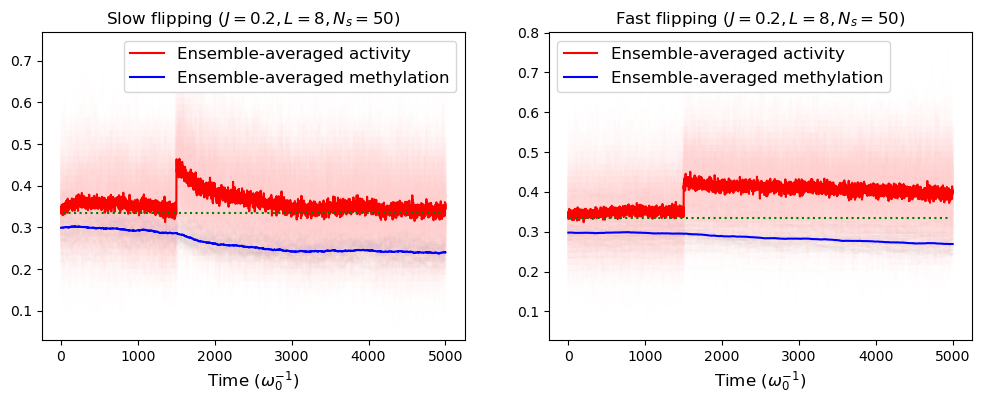

In [12]:
# test if this works
n_samples = 50
n_steps = 5000
step_change = int(0.3*n_steps)
tf = 5000
L = 8
J = 0.2
omega0 = 67.
kR = 0.075/omega0
kB = 0.15/omega0

# compare the different choices
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

####################
## First approach ##
####################

all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                               step_change=step_change,cnew=60,eps_bool=False)

# convert to activity 
ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)

# look at ensemble-averaged activity averaged over all spins for one realisation
for ff in range(n_samples):
    ax1.plot(t_grid,0.5+0.5*np.mean(all_states[0,ff,:,:,:],axis=(1,2)),color='pink',alpha=0.01)
    ax1.plot(t_grid,np.mean(all_states[1,ff,:,:,:],axis=(1,2)),color='grey',alpha=0.01)
    
ax1.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),color='red',label='Ensemble-averaged activity')
ax1.plot(t_grid,np.mean(ensemble_av[1,:,:,:], axis=(1,2)),color='blue',label='Ensemble-averaged methylation')
ax1.axhline(y=1/3,xmin=0.05,xmax=0.95,color='green',linestyle=':')
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax1.set_title(f'Slow flipping $(J={J}, L={L}, N_s={n_samples})$',size=12)
ax1.legend(fontsize=12)

#####################
## Second approach ##
#####################

omega0 = 6*67.
kR = 0.075/omega0
kB = 0.15/omega0

all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                               step_change=step_change,cnew=60,eps_bool=False)

# convert to activity 
ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)

# look at ensemble-averaged activity averaged over all spins for one realisation
for ff in range(n_samples):
    ax2.plot(t_grid,0.5+0.5*np.mean(all_states[0,ff,:,:,:],axis=(1,2)),color='pink',alpha=0.01)
    ax2.plot(t_grid,np.mean(all_states[1,ff,:,:,:],axis=(1,2)),color='grey',alpha=0.01)
    
ax2.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),color='red',label='Ensemble-averaged activity')
ax2.plot(t_grid,np.mean(ensemble_av[1,:,:,:], axis=(1,2)),color='blue',label='Ensemble-averaged methylation')
ax2.axhline(y=1/3,xmin=0.05,xmax=0.95,color='green',linestyle=':')
ax2.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax2.set_title(f'Fast flipping $(J={J}, L={L}, N_s={n_samples})$',size=12)
ax2.legend(fontsize=12)

plt.show()

## Visualing methylation

In [16]:
# obtain data
omega0 = 40
n_samples = 1
n_steps = 4000
step_change = 2500
tf = 1000
L = 80
J = 0.6
kR = 0.075/omega0
kB = 0.15/omega0

all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                               step_change=step_change,cnew=90,eps_bool=False)

all_states.shape

(2, 1, 4000, 80, 80)

<IPython.core.display.Javascript object>


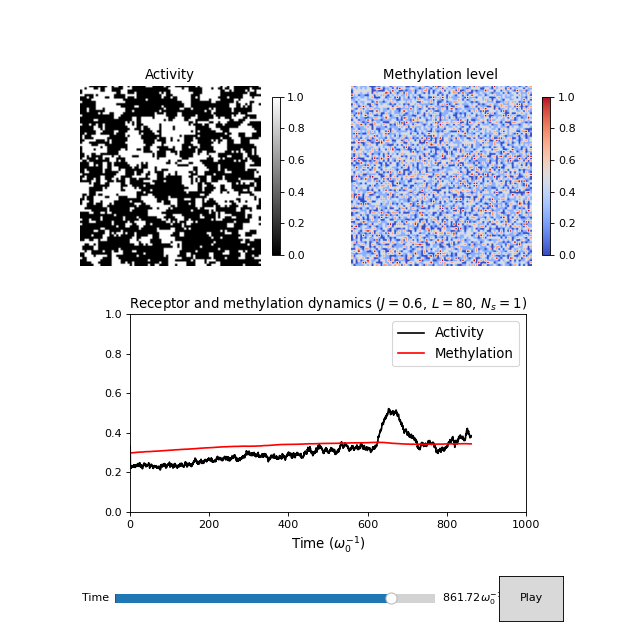

In [17]:
# interactive plot
%matplotlib notebook
#del(ax1, ax2, ax3)

# show the receptor cluster dynamically
fig = plt.figure(figsize=(8,8))

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, :])

# formatting
ax1.set_axis_off()
ax1.set_title('Activity')

ax2.set_axis_off()
ax2.set_title('Methylation level')

ax3.set_xlim(0,tf)
ax3.set_ylim(0,1)
ax3.set_aspect(tf//2)

# extract image objects for colorbars
im1 = ax1.imshow(0.5*ensemble_av[0,0,:,:] + 0.5, cmap=plt.cm.gray)
im2 = ax2.imshow(ensemble_av[1,0,:,:], cmap=plt.cm.coolwarm)

# add colourbars
fig.colorbar(im1, ax=ax1, shrink=0.8)
fig.colorbar(im2, ax=ax2, shrink=0.8)

# create a timeline for the animation
timeline = amp.Timeline(t_grid, units=r'$\omega_0^{-1}$', fps=500)

# create animation blocks for the lattices
spin_block = amp.blocks.Imshow(0.5*all_states[0,0,:,:,:] + 0.5, ax=ax1, cmap=plt.cm.gray)
meth_block = amp.blocks.Imshow(all_states[1,0,:,:,:], ax=ax2, cmap=plt.cm.coolwarm)

# create parametric plot
act = 0.5*all_states[0,0,:,:,:] + 0.5
y = np.mean(act,axis=(1,2))

T, Y = amp.util.parametric_line(t_grid, y)
T, M = amp.util.parametric_line(t_grid, np.mean(all_states[1,0,:,:,:], axis=(1,2)))

block_spin_line = amp.blocks.Line(T, Y, ax=ax3, label='Activity', color='k')
block_meth_line = amp.blocks.Line(T, M, ax=ax3, label='Methylation', color='r')

# more formatting
ax3.legend(loc='upper right',fontsize=12)
ax3.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax3.set_title(f'Receptor and methylation dynamics $(J={J},\, L={L},\, N_s={n_samples})$',size=12)

# create the animation and add a time bar
anim = amp.Animation([spin_block, meth_block, block_spin_line, block_meth_line], timeline)
anim.controls()

plt.show()

In [37]:
# reset to default
%matplotlib inline
del(ax1, ax2, ax3)

### Interpretation

-- write this after the meeting with Age --

## Fitting procedure

While the qualitative shape of the response is about right, we want to be more quantitative. Specifically, the phenomenological shape of the response kernel is

$$ \bar{K}(t) = G(1-\exp\{-t/\tau_1\})\exp\{-t/\tau_2\}, $$

with gain $G$, response time $\tau_1$ and adaptation time $\tau_2$. This kernel is related to the kernel used to fit the response in the absence of methylation. Concretely, the gain is a measure for the response strength, whereas $\tau_1$ sets how fast the cluster reacts (it is essentially the same as $\tau_r$). The novel feature is that the cluster adapts to the increased concentration, because of the methylation dynamics. This introduces the time scale $\tau_2$ over which this adaptation to the pre-stimulus level takes place. 

Mattingly et al. found that $G = 1.73 \pm 0.03$. For the time scales, we should not take the measurements too literal, but it is helpful to know that $\tau_1$ is in the order of 10-100 ms, whereas $\tau_2$ is in the order of 10 s. The question is therefore for what values of $J$ our model can reproduce these parameter values, at least to the right order of magnitude. 

We answer this question using a similar fitting procedure as we performed in the case without methylation, but with a slight change. Naively, we would extract the response kernel by shifting the activity down by its pre-stimulus level, rescale it by $\log(c_0/c_f)$ with $c_0=100 \, \mu$M and $c_f = 90 \, \mu$M, and shift time accordingly. However, the problem with this approach is that some of the fitting data becomes negative, which cannot be accounted for by the model. As it turns out, for the current model, this makes the fitting procedure break down, even for moderate values of $J$. 

Therefore, we would like to fit a kernel to $a(t)$ directly, rather than to the downshifted activity $\bar{a}(t) \equiv a(t) - a_0$. This can be done by adjusting the fitting function slightly. Per definition, $\bar{K}(t) = \bar{a}(t)/\log(c_0/c_f)$, so we can plug in the expressions for $\bar{K}(t)$ and $\bar{a}(t)$ to find

$$(a(t) - a_0)/\log(c_0/c_f) = G(1-\exp\{-t/\tau_1\})\exp\{-t/\tau_2\}.$$

Defining $K(t) \equiv a(t)/\log(c_0/c_f)$ and $K_0 \equiv a_0/\log(c_0/c_f)$, this expression becomes

$$K(t) = G(1-\exp\{-t/\tau_1\})\exp\{-t/\tau_2\} + K_0. $$

**Is this valid? Below I put some constraints on $K_0$ to avoid that the model becomes too flexible, but I am not entirely sure whether this is the way to do it**.

**ACTUALLY, leave out this shift, it only makes the fit more problematic because it sometimes fits a negative gain**

**Response: that makes no sense, silly, because then you are not really solving the problem, but just avoid shifting. However, the model then still cannot account for values below $K_0$**

This makes for a more convenient fitting function, because it does not require downshifting the activity. In principle, we could leave $K_0$ as a fitting parameter. However, the model should not become too flexible to avoid overfitting and in fact, we already have a reasonable estimate for $K_0$. After all, $K_0 = a_0/\log(c_0/c_f)$ and from experiment, it is known that $a_0 \approx 1/3$. The concentrations are also experimentally controllable. In particular, in the subsequent parts, we always start at $c_0 = 100 \, \mu$M and change the concentration to $c_f = 90 \, \mu$M, so we might as well plug in these values to estimate that 

$$ K_0 \approx 3.24. $$

We thus insert this valid into the expression for $K(t)$ and use this as a fitting function to extract $G$, $\tau_1$ and $\tau_2$.

Parameters of best fit: [G, tau1, tau2] = [2.91265226e-01 1.38191865e+00 1.69119032e+03]
Covariances: [[ 3.67619051e-06  5.20406815e-05 -6.04931851e-02]
 [ 5.20406815e-05  4.51048248e-02 -8.54189228e-01]
 [-6.04931851e-02 -8.54189228e-01  1.45807634e+03]]


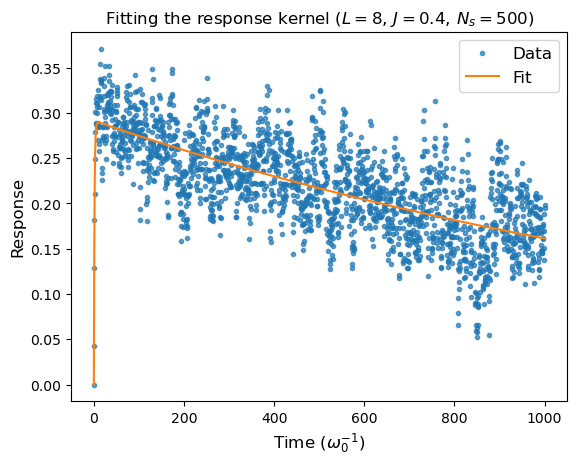

In [20]:
%matplotlib inline

# define the model function
def K(t,G,tau_1,tau_2):
    return G*(1-np.exp(-t/tau_1))*np.exp(-t/tau_2)

# set parameters
n_samples = 500
n_steps = 4000
step_change = 2000
tf = 2000
L = 8
J = 0.4
omega0 = 100.
kR = 0.075/omega0
kB = 0.15/omega0

# obtain results
all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                               step_change=step_change,cnew=90)

# convert to activity 
ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)

# test the fitting procedure
lattice_av = np.mean(ensemble_av_act,axis=(1,2))

# shift and rescale
shifted_activity = lattice_av[step_change-1:] - lattice_av[step_change-1]
response = shifted_activity/np.log(100/90)
shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

# perform fitting and store results
popt, pcov = curve_fit(K,shifted_time,response)

# show results
print('Parameters of best fit: [G, tau1, tau2] =', popt)
print('Covariances:', pcov)

plt.plot(shifted_time,response,'.',alpha=0.7,label='Data')
plt.plot(shifted_time,K(shifted_time,*popt),label='Fit')
plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Response',size=12)
plt.legend(fontsize=12)
plt.title(f'Fitting the response kernel $(L={L},\, J={J},\, N_s={n_samples})$')
plt.show()

#### Interpretation

The shape of the activity is what we would expect, so our simulation seems to produce the correct result, at least qualitatively. Additionally, we see that as the concentration is decreased, the activity goes up, followed by a decrease in methylation levels, which leads to adaptation. These observations align with the conceptual framework we have of chemotaxis. 

Still, we would like to further test how our model works, so we inspect what effect the size of the cluster is. For this purpose, we take a rough approach and consider a small, medium and large value of $L$ and take notice of any qualitative changes to the results.

In [ ]:
# check how the size of the cluster affects the results
n_samples = 50
n_steps = 4*10**3
step_change = 2*n_steps//3
tf = 2*10**3
L = 8
J = 0.4
kR = 0.075/omega0
kB = 0.15/omega0

# prepare figure
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
plt.tight_layout()

# lop through various L
L_arr = [3,10,20]

for L in L_arr:
    all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                               step_change=step_change,cbase=100,cnew=60)

    # convert to activity 
    ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)
    
    # show results
    ax1.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),label=f'L={L}')
    ax2.plot(t_grid,np.mean(ensemble_av[1,:,:,:],axis=(1,2)),label=f'L={L}')
    
# figure formatting
ax1.set_ylabel('Activity',size=12)
ax1.set_title(f'Effect of size on response kernel $(J={J},N_s={n_samples})$',size=12)
ax1.legend(fontsize=12)

ax2.set_ylabel('Methylation level',size=12)
ax2.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax2.legend(fontsize=12)

plt.show()

## Ratio of time scales for various $\omega_0$

The basic idea of this short section is to make sure that we choose $\omega_0$ in a consistent way. Concretely, our previous estimates of $\omega_0$ relied on two values: the response time $\tau_r$ for the response kernel without adaptation obtained from simulations and an experimental value, which we took to be 100 ms. In the case with adaptation, there is an additional parameter to be mindful of: the adaptation time scale $\tau_a$. We briefly show that this places another (albeit weak) constraint on $\omega_0$, so we should make sure that this constraint is consistent with our previous estimates.

How fast the cell adapts to a changed concentration level, depends on how fast (de)methylation proceeds. This process is governed by the rate constants $k_R$ and $k_B$. Their values in seconds are known, but since the simulation time is in units of $\omega_0^{-1}$, these rates must be rescaled accordingly. For that reason, the choice of $\omega_0$ influences how fast (de)methylation occurs and thus sets the adaptation time scale. 

A conventional choice for the adaptation (or methylation) time scale is in the order of 10 seconds, but we cannot yet translate this to a value in units of $\omega_0^{-1}$. Yet, it is clear that the response and adaptation happen on separated time scales. Specifically, if we assume that $\tau_r$ ranges between 10 and 100 ms, then the ratio of the time scales should be in the order of

$$\frac{\tau_a}{\tau_r} \sim 10^2 - 10^3. $$

The goal of this section is thus to determine for which $\omega_0$ this ratio is achieved. We can make qualitative arguments about how $\omega_0$ affects this ratio. For low $\omega_0$, spins flip relatively slowly compared to methylation. As such, activity switching and adaptation occur on a similar time scale, so we expect the raio $\tau_a/\tau_r$ to be small. Conversely, if spins flip very fast -- which is the case for a high $\omega_0$ -- then the response and adaptation should occur on vastly different time scales, meaning that the ratio goes up.

In order to test these ideas, we simulate the response kernel for a few values of $\omega_0$ over several orders of magnitude. For each response kernel, we obtain the relevant time scales and show their ratio.

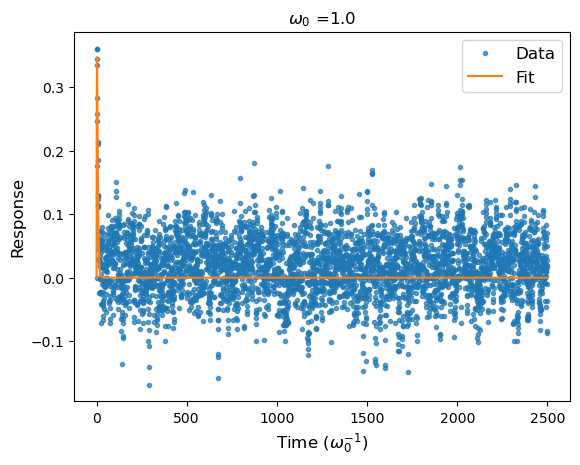

Progress: 10.0 %


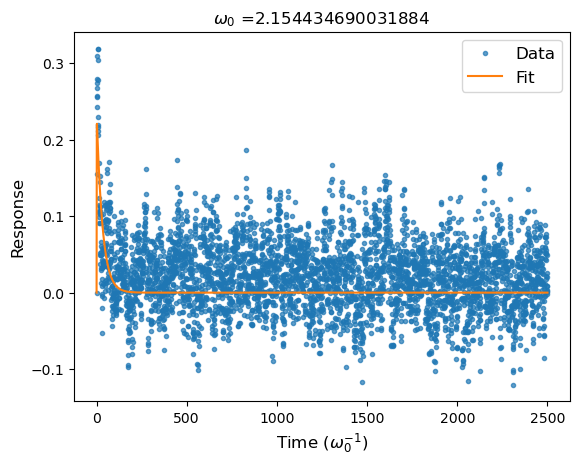

Progress: 20.0 %


/tmp/ipykernel_5355/1501086361.py:5: RuntimeWarning: overflow encountered in exp
  return G*(1-np.exp(-t/tau_1))*np.exp(-t/tau_2)


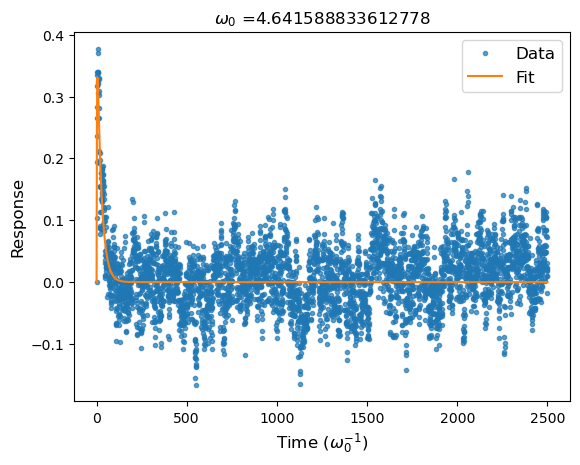

Progress: 30.0 %


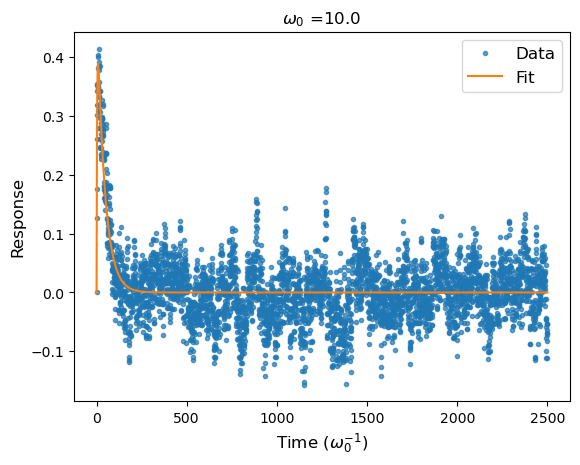

Progress: 40.0 %


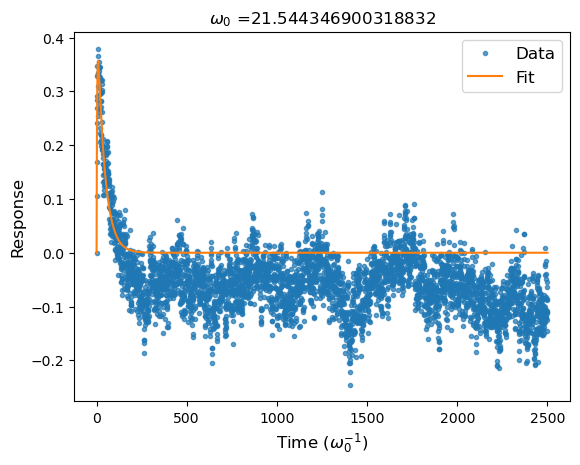

Progress: 50.0 %


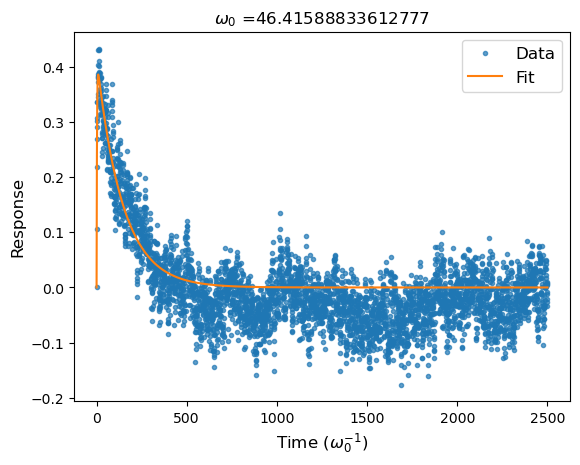

Progress: 60.0 %


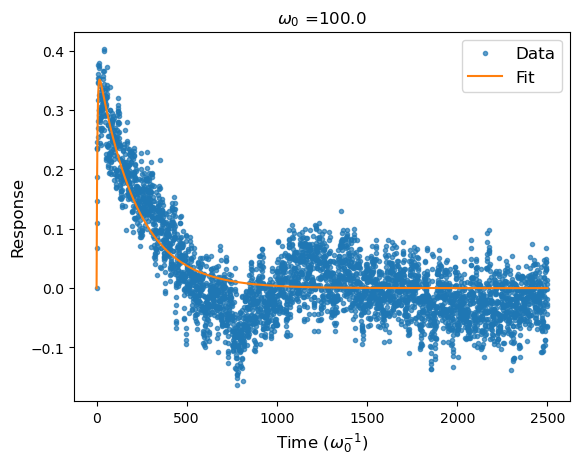

Progress: 70.0 %


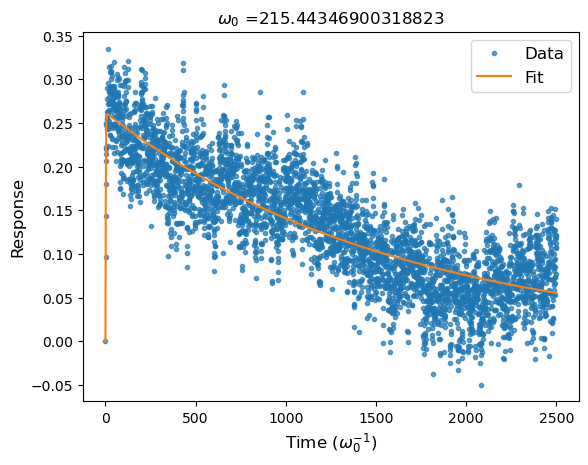

Progress: 80.0 %


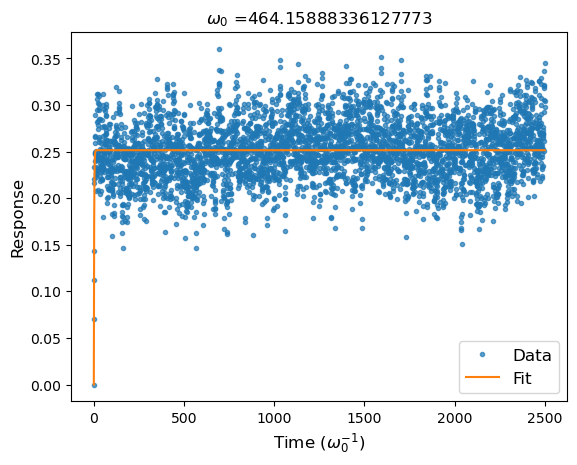

Progress: 90.0 %


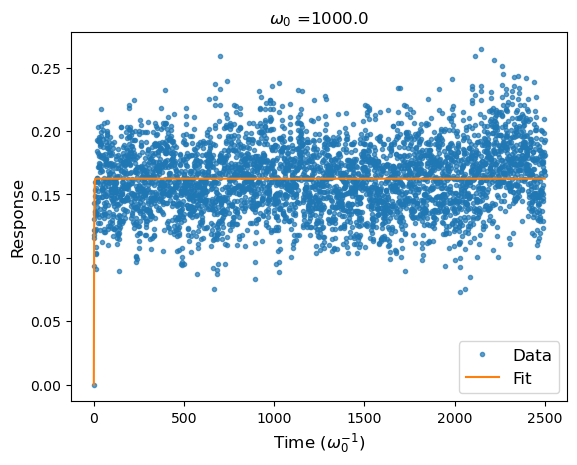

Progress: 100.0 %


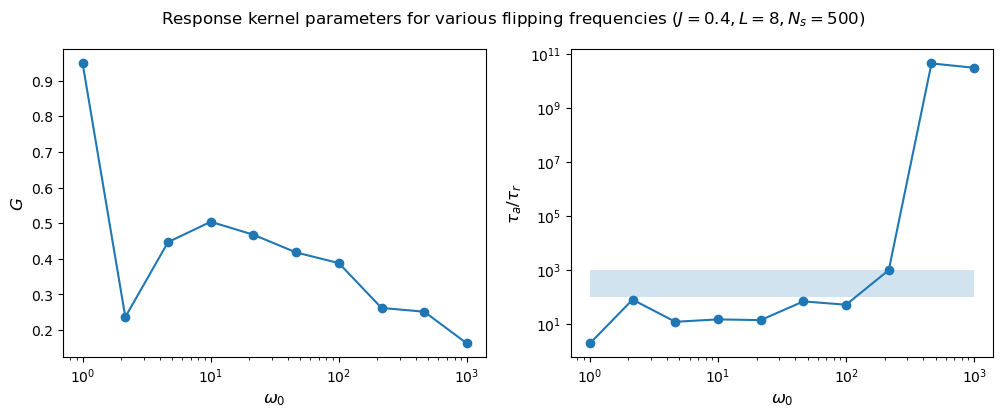

In [26]:
omega0_arr = np.logspace(0,3,10)

# set parameters
n_samples = 500
n_steps = 8000
step_change = 5000
tf = 5000
L = 8
J = 0.4

# array to store results
parm_arr = np.zeros((3,omega0_arr.size),dtype='float32')

# loop through the various omega0
for i,omega0 in enumerate(omega0_arr):
    # rescale rate constants
    kR = 0.075/omega0
    kB = 0.15/omega0

    # obtain results
    all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                                   step_change=step_change,cnew=90)

    # convert to activity 
    ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)

    # test the fitting procedure
    lattice_av = np.mean(ensemble_av_act,axis=(1,2))

    # shift and rescale
    shifted_activity = lattice_av[step_change-1:] - lattice_av[step_change-1]
    response = shifted_activity/np.log(100/90)
    shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

    # perform fitting and store results
    parm_arr[:,i], _ = curve_fit(K,shifted_time,response)
    
    # visual check
    plt.plot(shifted_time,response,'.',alpha=0.7,label='Data')
    plt.plot(shifted_time,K(shifted_time,*parm_arr[:,i]),label='Fit')
    plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
    plt.ylabel('Response',size=12)
    plt.legend(fontsize=12)
    plt.title(r'$\omega_0$ = ' + str(omega0))
    plt.show()

    print('Progress:',100*(i+1)/omega0_arr.size,'%')

# show results
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

fig.suptitle(f'Response kernel parameters for various flipping frequencies $(J={J},L={L},N_s={n_samples})$')

ax1.semilogx(omega0_arr,parm_arr[0,:],'-o')
ax1.set_xlabel(r'$\omega_0$',size=12)
ax1.set_ylabel(r'$G$',size=12)

ax2.loglog(omega0_arr,parm_arr[2,:]/parm_arr[1,:],'-o')
ax2.set_xlabel(r'$\omega_0$',size=12)
ax2.set_ylabel(r'$\tau_a/\tau_r$',size=12)
ax2.fill_between(omega0_arr,10**2,10**3,alpha=0.2)

plt.show()

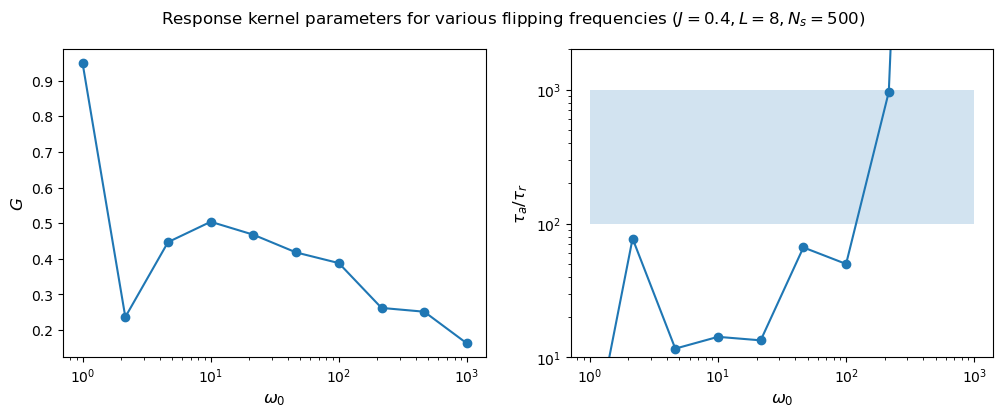

In [28]:
# show results
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

fig.suptitle(f'Response kernel parameters for various flipping frequencies $(J={J},L={L},N_s={n_samples})$')

ax1.semilogx(omega0_arr,parm_arr[0,:],'-o')
ax1.set_xlabel(r'$\omega_0$',size=12)
ax1.set_ylabel(r'$G$',size=12)

ax2.loglog(omega0_arr,parm_arr[2,:]/parm_arr[1,:],'-o')
ax2.set_xlabel(r'$\omega_0$',size=12)
ax2.set_ylabel(r'$\tau_a/\tau_r$',size=12)
ax2.fill_between(omega0_arr,10**2,10**3,alpha=0.2)
ax2.set_ylim(10,2000)

plt.show()

### Narrower search

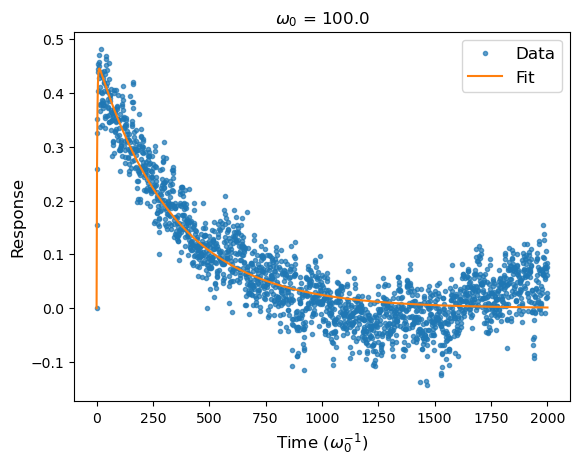

Progress: 20.0 %


/tmp/ipykernel_5355/1501086361.py:5: RuntimeWarning: overflow encountered in exp
  return G*(1-np.exp(-t/tau_1))*np.exp(-t/tau_2)
/tmp/ipykernel_5355/1501086361.py:5: RuntimeWarning: overflow encountered in multiply
  return G*(1-np.exp(-t/tau_1))*np.exp(-t/tau_2)


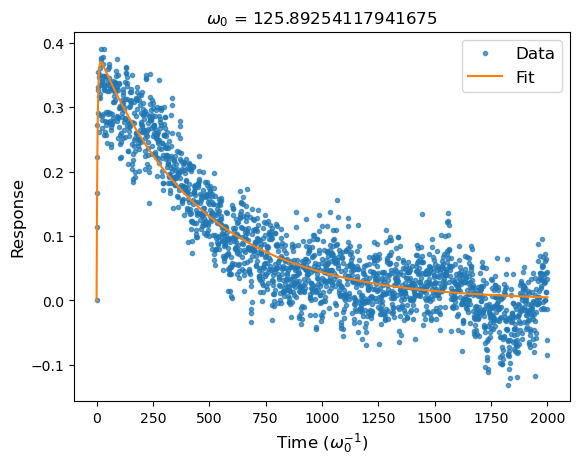

Progress: 40.0 %


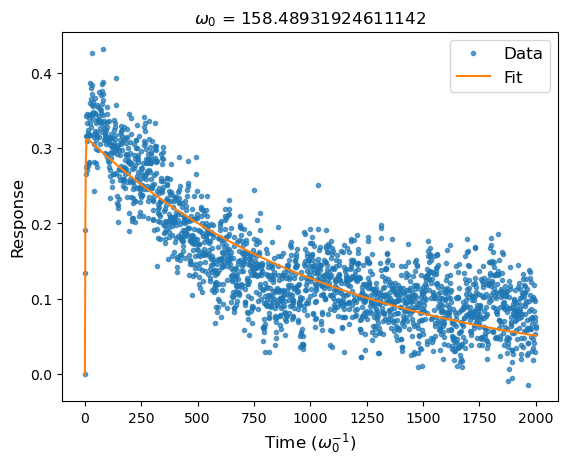

Progress: 60.0 %


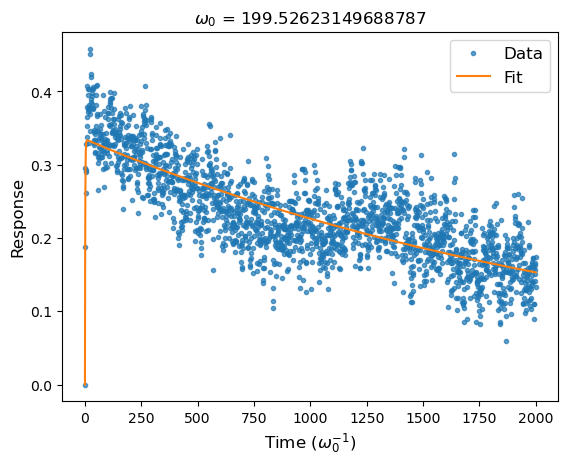

Progress: 80.0 %


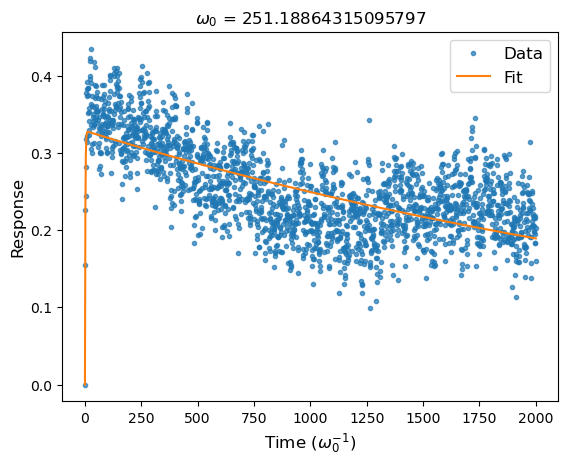

Progress: 100.0 %


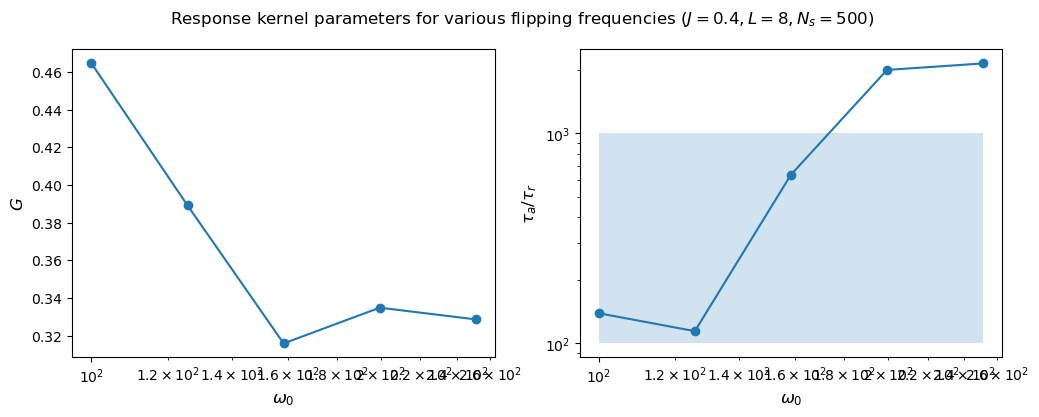

In [29]:
omega0_arr = np.linspace(60,230,5)

# set parameters
n_samples = 1000
n_steps = 5000
step_change = 2000
tf = 5000
L = 8
J = 0.4

# array to store results
parm_arr = np.zeros((3,omega0_arr.size),dtype='float32')

# loop through the various omega0
for i,omega0 in enumerate(omega0_arr):
    # rescale rate constants
    kR = 0.075/omega0
    kB = 0.15/omega0

    # obtain results
    all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                                   step_change=step_change,cnew=90)

    # convert to activity 
    ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)

    # test the fitting procedure
    lattice_av = np.mean(ensemble_av_act,axis=(1,2))

    # shift and rescale
    shifted_activity = lattice_av[step_change-1:] - lattice_av[step_change-1]
    response = shifted_activity/np.log(100/90)
    shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

    # perform fitting and store results
    parm_arr[:,i], _ = curve_fit(K,shifted_time,response)
    
    # visual check
    plt.plot(shifted_time,response,'.',alpha=0.7,label='Data')
    plt.plot(shifted_time,K(shifted_time,*parm_arr[:,i]),label='Fit')
    plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
    plt.ylabel('Response',size=12)
    plt.legend(fontsize=12)
    plt.title(r'$\omega_0$ = ' + str(omega0))
    plt.show()

    print('Progress:',100*(i+1)/omega0_arr.size,'%')

# show results
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

fig.suptitle(f'Response kernel parameters for various flipping frequencies $(J={J},L={L},N_s={n_samples})$')

ax1.semilogx(omega0_arr,parm_arr[0,:],'-o')
ax1.set_xlabel(r'$\omega_0$',size=12)
ax1.set_ylabel(r'$G$',size=12)

ax2.loglog(omega0_arr,parm_arr[2,:]/parm_arr[1,:],'-o')
ax2.set_xlabel(r'$\omega_0$',size=12)
ax2.set_ylabel(r'$\tau_a/\tau_r$',size=12)
ax2.fill_between(omega0_arr,10**2,10**3,alpha=0.2)

plt.show()

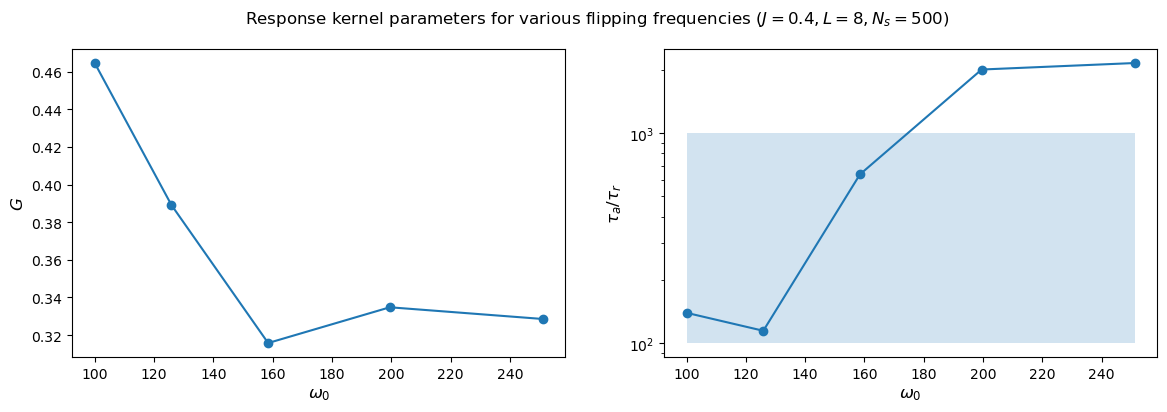

In [33]:
# show results
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,4))

fig.suptitle(f'Response kernel parameters for various flipping frequencies $(J={J},L={L},N_s={n_samples})$')

ax1.plot(omega0_arr,parm_arr[0,:],'-o')
ax1.set_xlabel(r'$\omega_0$',size=12)
ax1.set_ylabel(r'$G$',size=12)

ax2.semilogy(omega0_arr,parm_arr[2,:]/parm_arr[1,:],'-o')
ax2.set_xlabel(r'$\omega_0$',size=12)
ax2.set_ylabel(r'$\tau_a/\tau_r$',size=12)
ax2.fill_between(omega0_arr,10**2,10**3,alpha=0.2)

plt.show()

### Fitting parameters for various $J$

We now perform a similar investigation as in the case without methylation. Concretely, we extract the fitting parameters for various $J$ to see how the gain, response and adaptation time depend on the coupling constant.

**THIS NEEDS TO BE RUN STILL**

Parm. of best fit at J = 0.0: [G, tau1, tau2] =  [  0.12680082   1.53047753 110.44545212]
Parm. of best fit at J = 0.11: [G, tau1, tau2] =  [  0.13839661   0.71748726 121.96506358]
Parm. of best fit at J = 0.23: [G, tau1, tau2] =  [  0.17027988   1.1690868  145.48600268]
Parm. of best fit at J = 0.34: [G, tau1, tau2] =  [  0.19960151   0.81811095 169.66154506]


/tmp/ipykernel_6908/378847159.py:3: RuntimeWarning: overflow encountered in exp
  return G*(1-np.exp(-t/tau_1))*np.exp(-t/tau_2)


Parm. of best fit at J = 0.46: [G, tau1, tau2] =  [  0.28829818   1.00069003 266.45102524]


/tmp/ipykernel_6908/378847159.py:3: RuntimeWarning: overflow encountered in multiply
  return G*(1-np.exp(-t/tau_1))*np.exp(-t/tau_2)


Parm. of best fit at J = 0.57: [G, tau1, tau2] =  [ 0.5619845   2.718347   76.97237058]
Parm. of best fit at J = 0.69: [G, tau1, tau2] =  [ 2.65037454 22.72074802 25.56319146]
Parm. of best fit at J = 0.8: [G, tau1, tau2] =  [4.44345842e+03 4.29655178e+04 2.05639879e+01]


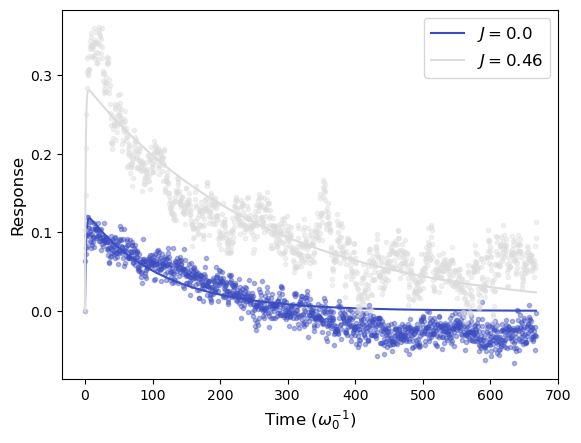

In [19]:
# define the model function
def K(t,G,tau_1,tau_2):
    return G*(1-np.exp(-t/tau_1))*np.exp(-t/tau_2)

# parameters
omega0 = 55
n_samples = 10**2
n_steps = 4*10**3
step_change = 2*n_steps//3
tf = 2*10**3
L = 10
kR = 0.075/omega0
kB = 0.15/omega0

# values of J to scan over
J_arr = np.linspace(0.,0.5,4)

# arrays to store fitted parameters and error bars
parm_arr = np.zeros((3,J_arr.size))
sd_arr = np.zeros_like(parm_arr)

# loop over all values of J
for i,J in enumerate(J_arr):
    # obtain data
    all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                               step_change=step_change,cbase=100,cnew=90)
    
    # convert to activity and average over all spins
    ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)
    lattice_av_act = np.mean(ensemble_av_act,axis=(1,2))

    # find response and shift time
    shifted_activity = lattice_av_act[step_change-1:] - lattice_av_act[step_change-1]
    response = shifted_activity/np.log(100/90)
    shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

    # perform fitting and store results
    popt, pcov = curve_fit(K,shifted_time,response)
    print(f'Parm. of best fit at J = {np.round(J,2)}: [G, tau1, tau2] = ', popt)
    parm_arr[:,i] = popt
    sd_arr[:,i] = [np.sqrt(pcov[j,j]) for j in range(3)]

    # visual check for a few values
    if i % 4 == 0:
        plt.plot(shifted_time,response,'.',alpha=0.4)
        plt.plot(shifted_time,K(shifted_time,*popt),label=f'$J={np.round(J,2)}$')

# get a nice color map
colormap = matplotlib.colormaps.get_cmap('coolwarm')

# count the number of plots
ax = plt.gca()
lines = ax.lines
n_plots = len(lines)

# apply the same color to each pair of plots
for plot in range(0, n_plots, 2):
    # choose a colour
    random_color = colormap(plot/n_plots)
    
    # colour the plots
    lines[plot].set_color(random_color)
    lines[plot+1].set_color(random_color)
    
plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Response',size=12)
plt.legend(fontsize=12)
plt.show()

array([4.44345842e+03, 4.29655178e+04, 2.05639879e+01])

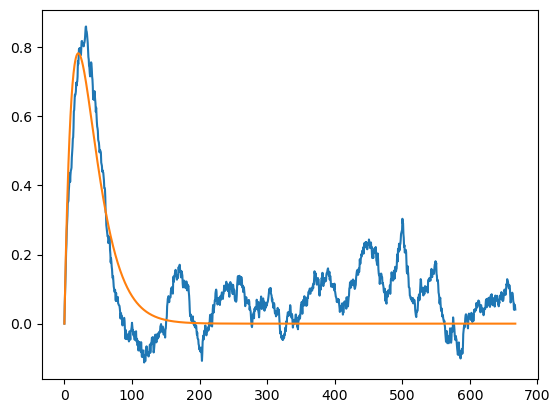

In [20]:
plt.plot(shifted_time,response)
plt.plot(shifted_time,K(shifted_time,*popt))

popt

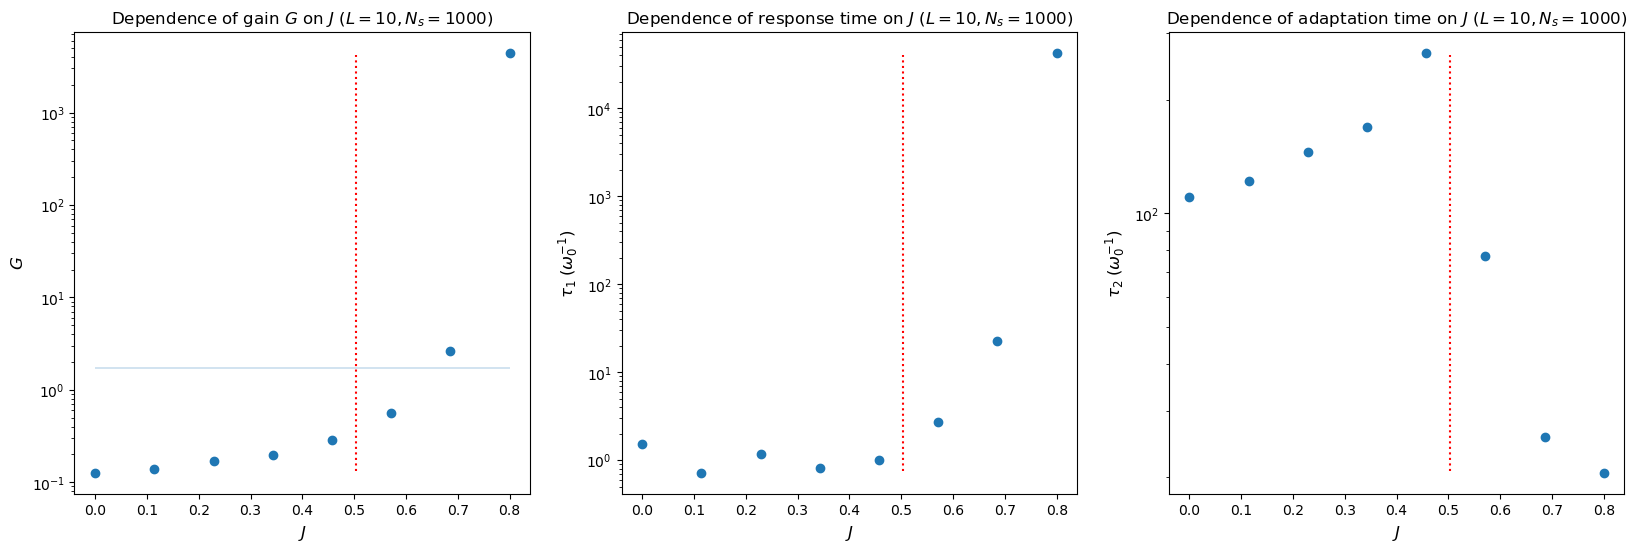

In [25]:
# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

# show how the fitting parameters depend on J
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,6))

for i,ax in enumerate((ax1, ax2, ax3)):
    ax.set_xlabel(r'$J$',size=12)
    ax.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,linestyle=':',color='r')
    
ax1.semilogy(J_arr,parm_arr[0,:],'o')
ax1.fill_between(J_arr,1.70,1.76,alpha=0.2)
ax1.set_ylabel(r'$G$',size=12)
ax1.set_title(f'Dependence of gain $G$ on $J$ ($L={L}, N_s={n_samples}$)')
#ax1.set_ylim(0,1)

ax2.semilogy(J_arr,parm_arr[1,:],'o')
ax2.set_ylabel(r'$\tau_1 \; (\omega_0^{-1})$',size=12)
ax2.set_title(f'Dependence of response time on $J$ ($L={L}, N_s={n_samples}$)')

ax3.semilogy(J_arr,parm_arr[2,:],'o')
ax3.set_ylabel(r'$\tau_2 \; (\omega_0^{-1})$',size=12)
ax3.set_title(f'Dependence of adaptation time on $J$ ($L={L}, N_s={n_samples}$)')

plt.show()

/tmp/ipykernel_6908/378847159.py:3: RuntimeWarning: overflow encountered in exp
  return G*(1-np.exp(-t/tau_1))*np.exp(-t/tau_2)
/tmp/ipykernel_6908/378847159.py:3: RuntimeWarning: overflow encountered in multiply
  return G*(1-np.exp(-t/tau_1))*np.exp(-t/tau_2)


Parm. of best fit at J = 0.5: [G, tau1, tau2] =  [ 0.40076566  1.94226837 96.28441437]
Parm. of best fit at J = 0.53: [G, tau1, tau2] =  [  0.35340961   1.16679406 145.51344148]
Parm. of best fit at J = 0.56: [G, tau1, tau2] =  [ 0.69606811  5.77638613 29.2851666 ]
Parm. of best fit at J = 0.59: [G, tau1, tau2] =  [ 0.53666187  2.41902782 82.34831573]
Parm. of best fit at J = 0.61: [G, tau1, tau2] =  [ 0.83494347  6.30338039 39.89201699]
Parm. of best fit at J = 0.64: [G, tau1, tau2] =  [ 927.45721855 6559.6613416    12.21092561]
Parm. of best fit at J = 0.67: [G, tau1, tau2] =  [ 1.2283252   9.27671008 35.00269761]
Parm. of best fit at J = 0.7: [G, tau1, tau2] =  [ 1917.2731667  15856.9441066     15.98866198]


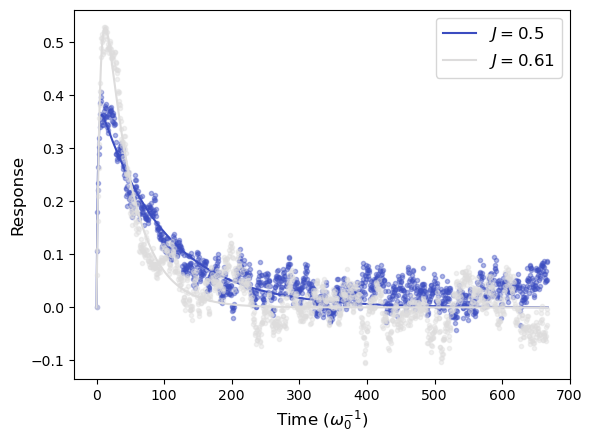

In [26]:
# parameters
n_samples = 10**3
n_steps = 4*10**3
step_change = 2*n_steps//3
tf = 2*10**3
L = 10
kR = 0.075/omega0
kB = 0.15/omega0

# values of J to scan over
J_arr = np.linspace(0.5,0.7,8)

# arrays to store fitted parameters and error bars
parm_arr = np.zeros((3,J_arr.size))
sd_arr = np.zeros_like(parm_arr)

# loop over all values of J
for i,J in enumerate(J_arr):
    # obtain data
    all_states, ensemble_av, t_grid = ensemble_averaged_meth_cross(n_samples,n_steps,tf,L,J,kR,kB,
                                                               step_change=step_change,cbase=100,cnew=90)
    
    # convert to activity and average over all spins
    ensemble_av_act = 0.5*(ensemble_av[0,:,:,:] + 1)
    lattice_av_act = np.mean(ensemble_av_act,axis=(1,2))

    # find response and shift time
    shifted_activity = lattice_av_act[step_change-1:] - lattice_av_act[step_change-1]
    response = shifted_activity/np.log(100/90)
    shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

    # perform fitting and store results
    popt, pcov = curve_fit(K,shifted_time,response)
    print(f'Parm. of best fit at J = {np.round(J,2)}: [G, tau1, tau2] = ', popt)
    parm_arr[:,i] = popt
    sd_arr[:,i] = [np.sqrt(pcov[j,j]) for j in range(3)]

    # visual check for a few values
    if i % 4 == 0:
        plt.plot(shifted_time,response,'.',alpha=0.4)
        plt.plot(shifted_time,K(shifted_time,*popt),label=f'$J={np.round(J,2)}$')

# get a nice color map
colormap = matplotlib.colormaps.get_cmap('coolwarm')

# count the number of plots
ax = plt.gca()
lines = ax.lines
n_plots = len(lines)

# apply the same color to each pair of plots
for plot in range(0, n_plots, 2):
    # choose a colour
    random_color = colormap(plot/n_plots)
    
    # colour the plots
    lines[plot].set_color(random_color)
    lines[plot+1].set_color(random_color)
    
plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Response',size=12)
plt.legend(fontsize=12)
plt.show()

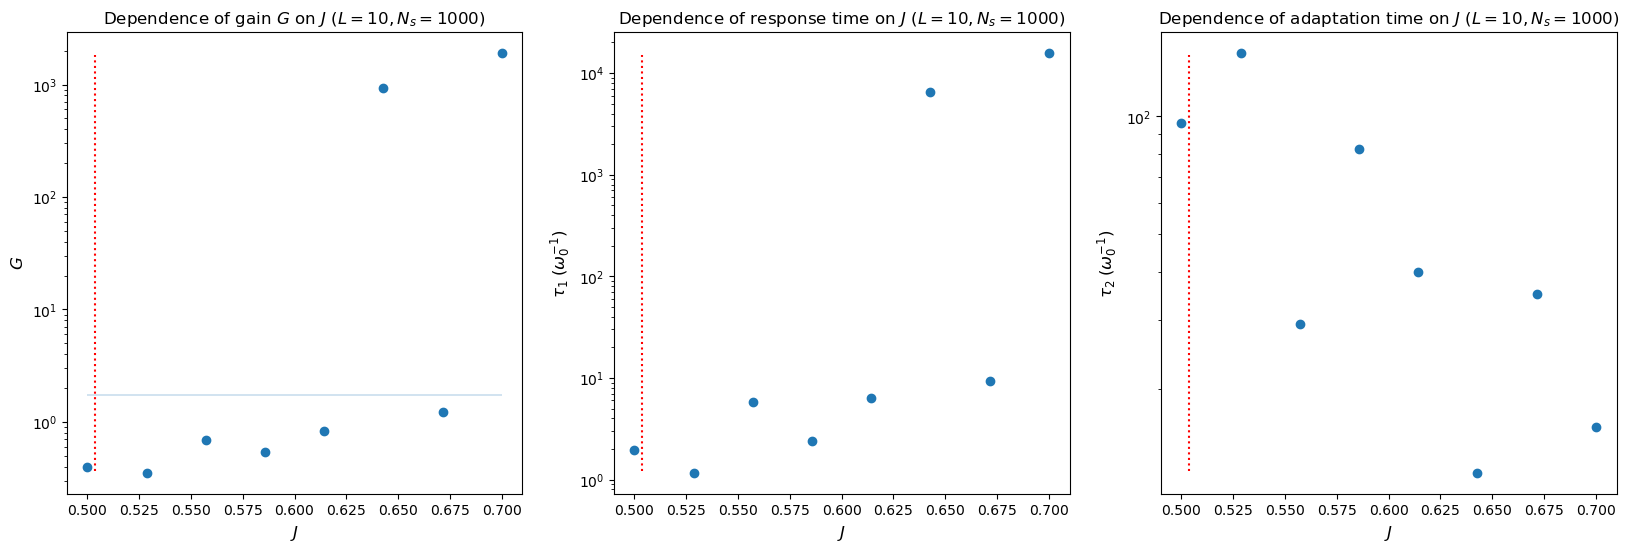

In [31]:
# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

# show how the fitting parameters depend on J
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,6))

for i,ax in enumerate((ax1, ax2, ax3)):
    ax.set_xlabel(r'$J$',size=12)
    ax.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,linestyle=':',color='r')
    
ax1.semilogy(J_arr,parm_arr[0,:],'o')
ax1.fill_between(J_arr,1.70,1.76,alpha=0.2)
ax1.set_ylabel(r'$G$',size=12)
ax1.set_title(f'Dependence of gain $G$ on $J$ ($L={L}, N_s={n_samples}$)')
#ax1.set_ylim(0.1,10)

ax2.semilogy(J_arr,parm_arr[1,:],'o')
ax2.set_ylabel(r'$\tau_1 \; (\omega_0^{-1})$',size=12)
ax2.set_title(f'Dependence of response time on $J$ ($L={L}, N_s={n_samples}$)')

ax3.semilogy(J_arr,parm_arr[2,:],'o')
ax3.set_ylabel(r'$\tau_2 \; (\omega_0^{-1})$',size=12)
ax3.set_title(f'Dependence of adaptation time on $J$ ($L={L}, N_s={n_samples}$)')

plt.show()

**TO DO**:
- take care of weird fitting; I suspect we are more or less leaving the linear regime f the system or there is too much noise, such that there are fluctuations in the response kernel. The fitting function will then only fit the first of those peaks, which sometimes results in unreasonable values for the fitting parameters
- add a linear regression between $\log G$ and $J$ 

## Noise kernel

Having incorporated methylation dynamics into our model, we now use our simulations to estimate the noise kernel proposed by Mattingly et al. The aim is to find the autocorrelator, which we do as follows. Firstly, we simulate a trajectory $a_i(t)$ on the cell level, meaning that it is averaged over $N_c = 400$ clusters. Since we are interested in the steady-state noise, the background concentration is kept constant at $c = 100\,\mu$M and the transient until reaching equilibrium is cut off. We repeat this procedure $N_s$ times to obtain the activities $a_1(t),...,a_{N_s}(t)$. The noise kernel is then defined as the autocorrelation of the activity with itself,

$$ N(t) \equiv \langle a(t)a(0) \rangle - \langle a(t) \rangle \langle a(0) \rangle, $$

with $t=0$ where the transient is cut off. Computing $N(t)$ thus requires taking ensemble averages over the sets $\{ a_1(t), ..., a_{N_s}(t)\}$, $\{a_1(0),...,a_{N_s}(0) \}$ and $\{a_1(t)a_1(0),...,a_{N_s}(t)a_{N_s}(0) \}$.

Measurements indicate that $x(t)$ is well approximated by an Ornstein-Uhlenbeck process, such that the noise kernel is of the form

$$ N(t) = \sigma_n^2 \exp\{-|t|/\tau_n\}, $$

where $\sigma_n$ sets the amplitude and $\tau_n$ the time scale of the fluctuations in $x(t)$. From their measurements, Mattingly et al. find that $\sigma_n = 0.092 \pm 0.002$ and $\tau_n = 11.75 \pm 0.04$ s, so the aim of this section is to check whether our simulations agree with these values. We expect that $\sigma_n^2$ scales as $N_c^{-0.5}$, because the noise is averaged over the $N_c$ clusters of the cell, so the choice of $N_c$ has a big effect on our results. Additionally, we are interested in assessing the effect of the coupling strength $J$ and array size $L$ on the results. 

In [42]:
@numba.jit(nopython=True)

# function for averaging over two axes
def lattice_mean(lattice):
    return np.sum(np.sum(lattice[:,:,:],axis=-1),axis=-1)/lattice[0,:,:].size

@numba.jit(nopython=True)
# function for finding several realisations of single-cell activity
def activity_finder(n_steps,tf,n_samples,Nc,L,J,kR,kB):
    # array to save results
    all_act = np.zeros((n_steps,n_samples))
    
    for sample in range(n_samples):
        # obtain a realisation
        _, cell_av, time = ensemble_averaged_meth_cross(Nc,n_steps,tf,L,J,kR,kB,cbase=100)
        
        # extract activity
        all_act[:,sample] = 0.5*(lattice_mean(cell_av[0,:,:,:]) + 1)
        
    return all_act, time

def autocorr(all_act,time,co):   
    # obtain average of product 
    ata0_av = np.mean(all_act[co:,:]*all_act[co,:],axis=1)
    
    # obtain factors for product of averages
    at_av = np.mean(all_act[co:,:],axis=1)
    a0_av = np.mean(all_act[co,:])
    
    # shift time
    time_s = time[co:] - time[co]
    
    # return the autocorrelator: average of product minus product of averages
    return ata0_av-at_av*a0_av, time_s

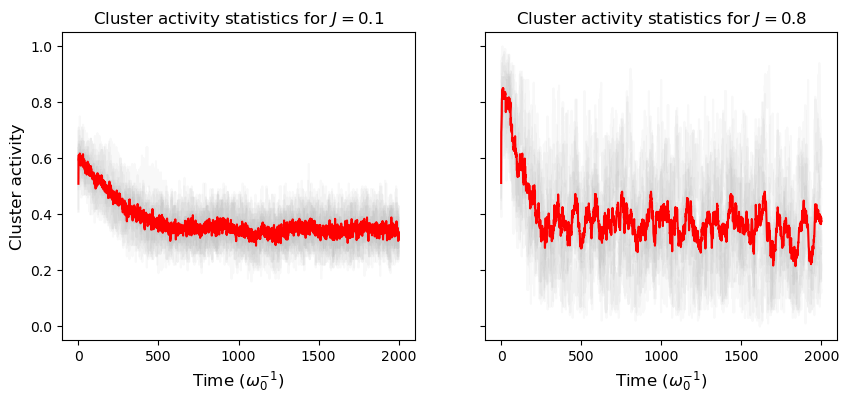

In [6]:
# time-related parameters
n_steps = 2500
tf = 2000

# cluster-related parameters
n_samples = 10
Nc = 4
L = 5
kR = 0.075/omega0
kB = 0.15/omega0

all_act_low_J, time = activity_finder(n_steps,tf,n_samples,Nc,L,0.1,kR,kB)

all_act_high_J, time = activity_finder(n_steps,tf,n_samples,Nc,L,0.8,kR,kB)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4),sharey=True)

for ff in range(n_samples):
    ax1.plot(time,all_act_low_J[:,ff],color='grey',alpha=0.05)
    ax2.plot(time,all_act_high_J[:,ff],color='grey',alpha=0.05)
    
ax1.plot(time,np.mean(all_act_low_J,axis=1),color='red')
ax2.plot(time,np.mean(all_act_high_J,axis=1),color='red')

ax1.set_title(r'Cluster activity statistics for $J=0.1$')
ax2.set_title(r'Cluster activity statistics for $J=0.8$')

ax1.set_ylabel(r'Cluster activity',size=12)
ax1.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax2.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)

plt.show()

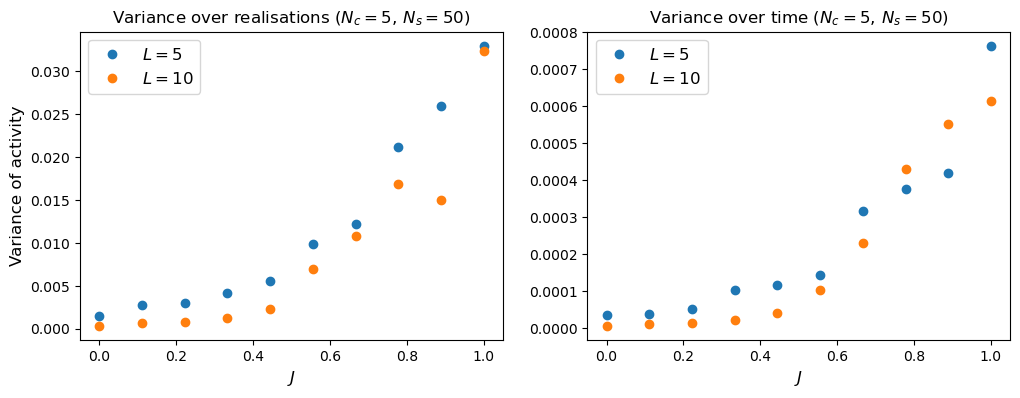

In [27]:
# check the variance over the realisations and over time
J_arr = np.linspace(0.,1.,10)
L_arr = [5,10]

# time-related parameters
n_steps = 1000
tf = 2000
co = 2*n_steps//3

# cluster-related parameters
n_samples = 50
Nc = 5
kR = 0.075/omega0
kB = 0.15/omega0

# arrays to store results
var_ensem = np.zeros((J_arr.size,2))
var_time = np.zeros_like(var_ensem)

# loop over various values of J
for i,J in enumerate(J_arr):
    for j,L in enumerate(L_arr):
        # obtain all activities
        all_act, _ = activity_finder(n_steps,tf,n_samples,Nc,L,J,kR,kB)

        # obtain ensemble average from the cut-off
        av_act = np.mean(all_act[co:,:],axis=1)

        # compute the relevant variances
        var_ensem[i,j] = np.var(all_act[-1,:])
        var_time[i,j] = np.var(av_act)

# show results
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.plot(J_arr,var_ensem[:,0],'o',label=f'$L={L_arr[0]}$')
ax1.plot(J_arr,var_ensem[:,1],'o',label=f'$L={L_arr[1]}$')
ax1.set_xlabel(r'$J$',size=12)
ax1.set_ylabel(r'Variance of activity',size=12)
ax1.legend(fontsize=12)
ax1.set_title(f'Variance over realisations $(N_c={Nc},\, N_s={n_samples})$')

ax2.plot(J_arr,var_time[:,0],'o',label=f'$L={L_arr[0]}$')
ax2.plot(J_arr,var_time[:,1],'o',label=f'$L={L_arr[1]}$')
ax2.set_xlabel(r'$J$',size=12)
ax2.legend(fontsize=12)
ax2.set_title(f'Variance over time $(N_c={Nc},\, N_s={n_samples})$')

plt.show()

### Interpretation

For higher $J$, we observe two interesting statistics:
- the variance between realisations of the cluster activity increases (the grey lines);
- the variance over time of the ensemble-averaged cluster activity increases (the red lines).

We can explain the first observations by the fact that for higher $J$, it is more likely that the cluster is in a more extreme conformation, i.e. many receptors having the same activity status. As such, the different realisations of the cluster activity will differ more from each other, meaning that the variance of the ensemble-averaged cluster activity is higher for a stronger coupling. With the noise kernel in mind, we expect that this means that the amplitude of the noise will be higher for larger $J$.

For the second observation, realise that a higher value of $J$ means that more spins will flip in concert. As such, it is reasonable to expect more fluctuations in the average cluster activity over time. After all, for a high value of $J$, it is more likely that many spins will flip together to drastically change the activity of the entire cluster than for a low value of $J$. This explains why the cluster activity varies strongly over time. Regarding the noise kernel, we expect that this means that the correlation time will be shorter for higher $J$ (i.e., if many spins flip in concert, the system forgets its previous state much faster).

Indeed, plotting the variances over realisations and over time versus $J$ confirms the above claims. That is, both the variance between different realisations of the cluster activity as well as the fluctuations over time increase as $J$ increases. Furthermore, we note that both variances tend to be, on average, lower for a larger system. This plausibly results from the fact that the activity is always averaged over the lattice, such that having more spins already lowers the variance in the activity.

**IDEA: also measure noise kernel for case without methylation, just to see the effect of this. I expect that it will largely affect the correlation time scale.**

Parameters of best fit: [sigma_n, tau_n] = [3.61022740e-03 2.24731089e+02]
Standard deviations: [2.9238004668472786e-05, 6.1254395000706285]
Converted units: tau_n = 8.989243552985972 s


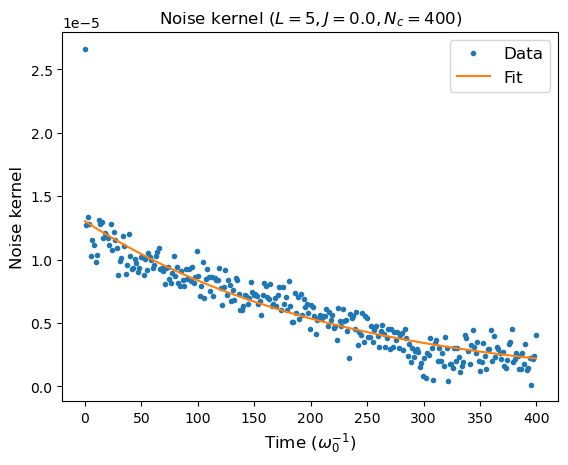

In [21]:
# time-related parameters
n_steps = 5000
tf = 2000
co = 2000

# cluster-related parameters
n_samples = 100
Nc = 400
L = 5
J = 0.
kR = 0.075/omega0
kB = 0.15/omega0

# obtain activities
all_act, time = activity_finder(n_steps,tf,n_samples,Nc,L,J,kR,kB)

# obtain autocorrelation
auto_corr, time_s = autocorr(all_act,time,co)

# fitting the noise kernel
def noise_kernel(t,sigma_n,tau_n):
    return sigma_n**2*np.exp(-t/tau_n)

# perform fitting and store results
popt_nlit, pcov_nlit = curve_fit(noise_kernel,time_s,auto_corr)

# print results
print('Parameters of best fit: [sigma_n, tau_n] =',popt_nlit)
print('Standard deviations:',[np.sqrt(pcov_nlit[i,i]) for i in range(2)])
print(f'Converted units: tau_n = {popt_nlit[1]*0.04} s')

# show fit along with the data
plt.plot(time_s,auto_corr,'.',label='Data')
plt.plot(time_s,noise_kernel(time_s,*popt_nlit),label='Fit')
plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Noise kernel',size=12)
plt.title(f'Noise kernel $(L={L},J={J},N_c={Nc})$')
plt.legend(fontsize=12)
plt.show()

### Interpretation

-- Write this --

60
Parameters of best fit: [sigma_n, tau_n] = [2.32241167e-02 5.50839513e+02]
Standard deviations: [0.0001083847956081682, 8.562294949485068]
Converted units: tau_n = 22.03358050688588 s


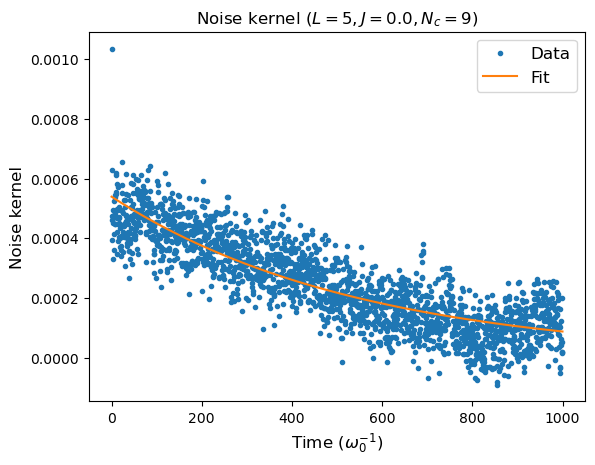

In [44]:
print(omega0)

# time-related parameters
n_steps = 4000
tf = 2000
co = 2000

# cluster-related parameters
n_samples = 120
Nc = 9
L = 5
J = 0.
kR = 0.075/omega0
kB = 0.15/omega0

# fitting the noise kernel
def noise_kernel(t,sigma_n,tau_n):
    return sigma_n**2*np.exp(-t/tau_n)

# obtain activities
all_act, time = activity_finder(n_steps,tf,n_samples,Nc,L,J,kR,kB)

# obtain autocorrelation
auto_corr, time_s = autocorr(all_act,time,co)

# perform fitting and store results
popt_nadj, pcov_nadj = curve_fit(noise_kernel,time_s,auto_corr)

# print results
print('Parameters of best fit: [sigma_n, tau_n] =',popt_nadj)
print('Standard deviations:',[np.sqrt(pcov_nadj[i,i]) for i in range(2)])
print(f'Converted units: tau_n = {popt_nadj[1]/omega0} s')

# show fit along with the data
plt.plot(time_s,auto_corr,'.',label='Data')
plt.plot(time_s,noise_kernel(time_s,*popt_nadj),label='Fit')
plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Noise kernel',size=12)
plt.title(f'Noise kernel $(L={L},J={J},N_c={Nc})$')
plt.legend(fontsize=12)
plt.show()

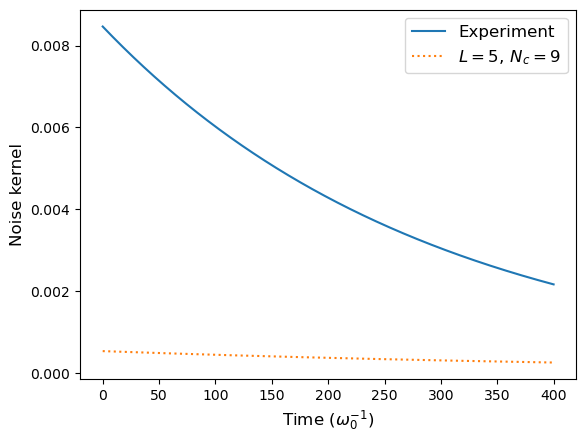

In [45]:
# show the experimental and fitted results in one plot
t_grid = np.linspace(0,400,10**3)

plt.plot(t_grid,noise_kernel(t_grid,0.092,11.75*25),label='Experiment')
#plt.plot(t_grid,noise_kernel(t_grid,*popt_nlit),':',label=r'$L=5,\, N_c = 400$')
plt.plot(t_grid,noise_kernel(t_grid,*popt_nadj),':',label=r'$L=5,\, N_c = 9$')

plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Noise kernel',size=12)
plt.legend(fontsize=12)

plt.show()

### Extracting Noise Kernel for Various $J$

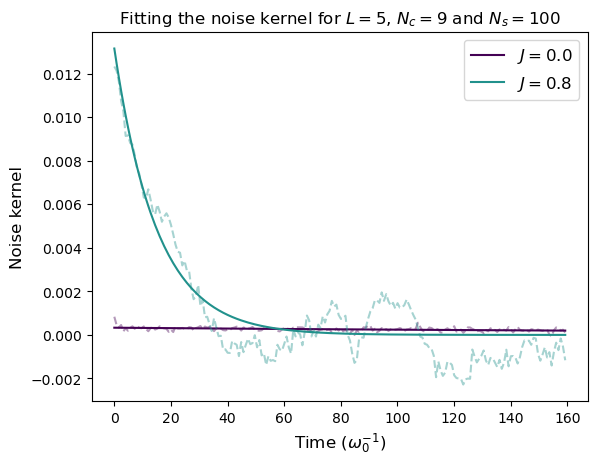

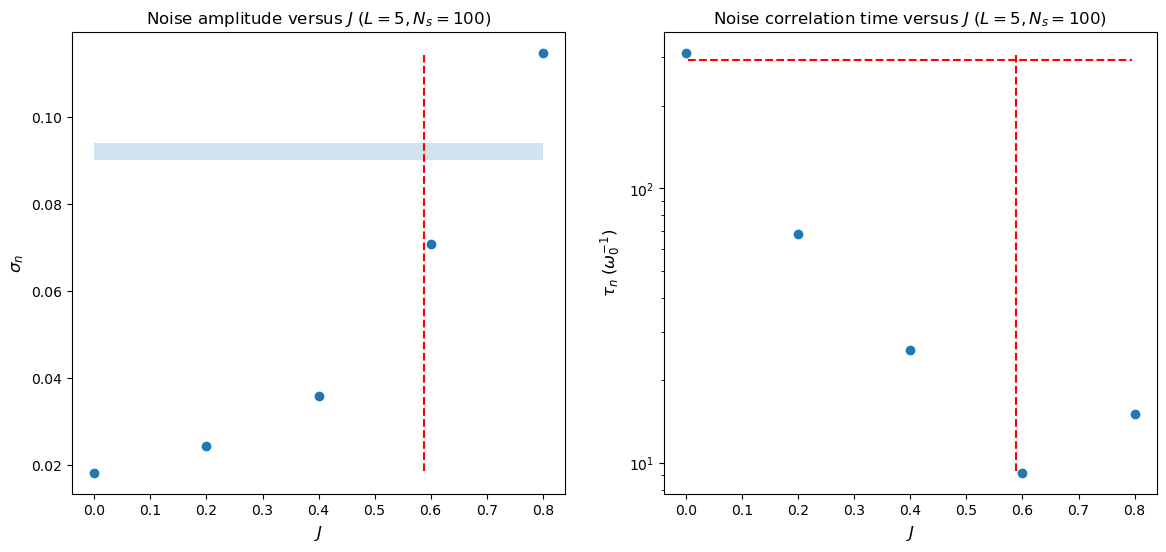

In [99]:
# fitting the noise kernel
def noise_kernel(t,sigma_n,tau_n):
    return sigma_n**2*np.exp(-t/tau_n)

# time-related parameters
n_steps = 2500
tf = 2000
co = 2300

# cluster-related parameters
n_samples = 100
Nc = 9
L = 5
J_arr = np.linspace(0.,0.8,5)
kR = 0.075/omega0
kB = 0.15/omega0

# arrays to store the results
parm_arr = np.zeros((2,J_arr.size))
sd_arr = np.zeros_like(parm_arr)

# loop over all J
for idx, J in enumerate(J_arr):
    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,Nc,L,J,kR,kB)

    # obtain autocorrelation
    auto_corr, time_s = autocorr(all_act,time,co)
    
    # perform fitting and store results
    parm_arr[:,idx], pcov = curve_fit(noise_kernel,time_s,auto_corr)
    sd_arr[:,idx] = [np.sqrt(pcov[i,i]) for i in range(2)]
    
    # a few visual checks
    if idx % 4 == 0:
        plt.plot(time_s,auto_corr,'--',alpha=0.4)
        plt.plot(time_s,noise_kernel(time_s,*parm_arr[:,idx]),label=f'$J={np.round(J,2)}$')
        
# formatting
plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Noise kernel',size=12)
plt.title(f'Fitting the noise kernel for $L={L}$, $N_c={Nc}$ and $N_s={n_samples}$')

# get a nice color map
colormap = matplotlib.colormaps.get_cmap('viridis')

# count the number of plots
ax = plt.gca()
lines = ax.lines
n_plots = len(lines)

# apply the same color to each pair of plots
for plot in range(0, n_plots, 2):
    # choose a colour
    random_color = colormap(plot/n_plots)
    
    # colour the plots
    lines[plot].set_color(random_color)
    lines[plot+1].set_color(random_color)

plt.legend(fontsize=12)
plt.show()

# show how the fitting parameters depend on J
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

for i,ax in enumerate((ax1, ax2)):
    ax.set_xlabel(r'$J$',size=12)
    ax.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,linestyle='--',color='r')
    
ax1.plot(J_arr,parm_arr[0,:],'o')
ax1.fill_between(J_arr,0.090,0.094,alpha=0.2)
ax1.set_ylabel(r'$\sigma_n$',size=12)
ax1.set_title(f'Noise amplitude versus $J$ ($L={L}, N_s={n_samples}$)')

ax2.semilogy(J_arr,parm_arr[1,:],'o')
ax2.axhline(y=11.75*25,xmin=0.05,xmax=0.95,color='red',linestyle='--')
ax2.set_ylabel(r'$\tau_n \; (\omega_0^{-1})$',size=12)
ax2.set_title(f'Noise correlation time versus $J$ ($L={L}, N_s={n_samples}$)')

plt.show()

SystemError: CPUDispatcher(<function activity_finder at 0x7fed39d54540>) returned a result with an exception set

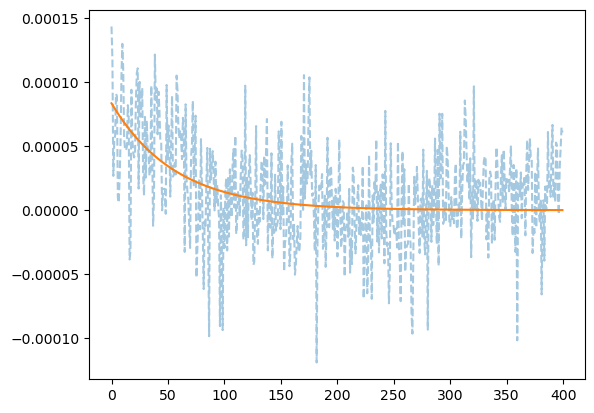

In [95]:
# time-related parameters
n_steps = 2500
tf = 2000
co = 2000

# cluster-related parameters
n_samples = 20
Nc = 9
L = 10
J_arr = np.linspace(0.,0.8,10)
kR = 0.075/omega0
kB = 0.15/omega0

# arrays to store the results
parm_arr = np.zeros((2,J_arr.size))
sd_arr = np.zeros_like(parm_arr)

# loop over all J
for idx, J in enumerate(J_arr):
    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,Nc,L,J,kR,kB)

    # obtain autocorrelation
    auto_corr, time_s = autocorr(all_act,time,co)
    
    # perform fitting and store results
    parm_arr[:,idx], pcov = curve_fit(noise_kernel,time_s,auto_corr)
    sd_arr[:,idx] = [np.sqrt(pcov[i,i]) for i in range(2)]
    
    # a few visual checks
    if idx % 4 == 0:
        plt.plot(time_s,auto_corr,'--',alpha=0.4)
        plt.plot(time_s,noise_kernel(time_s,*parm_arr[:,idx]),label=f'$J={np.round(J,2)}$')
        
# formatting
plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Noise kernel',size=12)
plt.title(f'Fitting the noise kernel for $L={L}$')

# get a nice color map
colormap = matplotlib.colormaps.get_cmap('viridis')

# count the number of plots
ax = plt.gca()
lines = ax.lines
n_plots = len(lines)

# apply the same color to each pair of plots
for plot in range(0, n_plots, 2):
    # choose a colour
    random_color = colormap(plot/n_plots)
    
    # colour the plots
    lines[plot].set_color(random_color)
    lines[plot+1].set_color(random_color)

plt.legend(fontsize=12)
plt.show()

# show how the fitting parameters depend on J
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

for i,ax in enumerate((ax1, ax2)):
    ax.set_xlabel(r'$J$',size=12)
    ax.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,linestyle='--',color='r')
    
ax1.plot(J_arr,parm_arr[0,:],'o')
ax1.fill_between(J_arr,0.090,0.094,alpha=0.2)
ax1.set_ylabel(r'$\sigma_n$',size=12)
ax1.set_title(f'Noise amplitude versus $J$ ($L={L}, N_s={n_samples}$)')

ax2.semilogy(J_arr,parm_arr[1,:],'o')
ax2.axhline(y=11.75,xmin=0.05,xmax=0.95,color='red',linestyle='--')
ax2.set_ylabel(r'$\tau_n \; (\omega_0^{-1})$',size=12)
ax2.set_title(f'Noise correlation time versus $J$ ($L={L}, N_s={n_samples}$)')

plt.show()